# 🏆 Welcome to the LLM Triathlon Engine 🏆

Welcome to the **LLM Triathlon Engine**! This notebook is an automated framework designed to rigorously test and benchmark multiple Large Language Models (LLMs) from various providers (like OpenAI, Groq, and local Ollama) in a fair and comprehensive "triathlon."

---

> ### 🏊‍♂️🚴‍♂️🏃‍♂️ The Triathlon Concept
>
> A simple 100m dash (one question) isn't enough to find the best all-around model. A triathlon tests endurance and skill across three different events with *different weights*. Our engine does the same:
> * **Event 1 (Heavy):** A "heavy-weight" question (worth **50 points**)
> * **Event 2 (Medium):** A "medium-weight" question (worth **30 points**)
> * **Event 3 (Light):** A "light-weight" question (worth **20 points**)
>
> The final winner is the model with the highest **total weighted score** across all three events.

---

## 🚀 How It Works: The 8-Stage Pipeline

This engine runs in a sequential pipeline. Here is the step-by-step "bulletin board" for how it functions:

| Stage | Emoji | Description | Key Output |
| :--- | :--- | :--- | :--- |
| **Stage 1** | ⚙️ | **Setup & Client Init**<br>Dynamically checks all your `os.getenv()` API keys (OpenAI, Groq, etc.) and your local Ollama server. It then builds the list of **available** models to compete. | `competitors` (list) |
| **Stage 2** | 🧠 | **Question Generation**<br>Uses a "Generator" LLM to create 3 diverse, high-quality questions. It then uses a "Consultant" LLM to rank them and assign the **50, 30, and 20-point** weights. | `questions` (list) |
| **Stage 3** | 🏃‍♂️ | **The Race (Execution)**<br>The main engine. It loops through every *available* model (`competitors`) and asks it *all three* ranked questions (`questions`), dynamically using the correct API client for each. | `all_answers` (dict) |
| **Stage 4** | 📊 | **Answer Visualization**<br>Renders all raw answers in a clean, **question-by-question** format. This allows you, the user, to manually inspect and compare the performance on each task. | *Markdown Output* |
| **Stage 5** | 🏗️ | **Judge Data Formatting**<br>Combines *all* answers from all models into a single, massive, and meticulously labeled text string (`together_string`) ready to be sent to the Judge. | `together_string` (str) |
| **Stage 6** | ⚖️ | **The "Judge" Call**<br>Sends the massive prompt (with `together_string`) to a powerful Judge LLM (`gpt-4o`). It requests a **nested JSON** response containing 6 scores per model. | `judge_data_str` (JSON) |
| **Stage 7** | 🧮 | **Final Score Calculation**<br>Parses the Judge's JSON. Applies the **two-layer weighting system:**<br> 1. `(Judge Score * 0.6) + (Peer Score * 0.4)`<br> 2. `(Q1 * 0.5) + (Q2 * 0.3) + (Q3 * 0.2)` | `final_rankings_sorted` (list) |
| **Stage 8** | 🥇 | **The Podium (Graphing)**<br>Uses `matplotlib` to plot the final results in a horizontal bar chart. The winning model with the highest total score is highlighted in **gold**. | *Visual Bar Chart* |





In [1]:
# Start with imports - ask ChatGPT to explain any package that you don't know

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic
from IPython.display import Markdown, display

In [7]:
# Always remember to do this!
load_dotenv(override=True)

True

# ⚙️ Stage 0 : Competition Setup and Client Initialization

This block prepares the foundational infrastructure for the LLM competition. It checks all available API keys defined in environment variables and dynamically adds only the **accessible** models to the list of competitors. This ensures the robustness and flexibility of our testing environment.

| Task | Purpose | Control Mechanism |
| :--- | :--- | :--- |
| **API Key Detection** | Determines which services can be used. | Checks for the presence of keys using `os.getenv()`. |
| **Client Initialization** | Creates `OpenAI` compatible clients using the correct `base_url` and `api_key` for each service. | **Example:** Uses specific `base_url` for providers like Groq and DeepSeek. |
| **Ollama Check** | Tests whether the local server is active. | Sends an HTTP request via `requests` to check `http://localhost:11434`. |
| **Competitor List** | Adds each initialized model (with its client, model ID, and display name) to the `competitors` list. | Only `✅ Successful` models proceed to the next stage. |

***Please verify any instances of "❌ ERROR" or "❌ Not Set" in the output.***

In [60]:
# Stage 0
# Print the key prefixes to help with any debugging
import os
import time
from openai import OpenAI
import requests 

# --- Stage 0: Initialization and Variable Definitions ---

# Initialize the questions list
questions = []

# Initialize the competitors list as empty
competitors = []

print("--- 🏁 Setup Check: API Keys and Clients ---")

# --- Stage 1: Retrieve API Keys from Environment Variables ---
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY") 
deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

# --- Stage 2: Check and Initialize Clients ---

# --- OpenAI Check ---
if openai_api_key:
    print(f"✅ OpenAI API Key found (Starts: {openai_api_key[:8]}...)")
    try:
        openai_client = OpenAI(api_key=openai_api_key)
        # Note: Model name 'gpt-4.1' is not official and likely to cause errors. Using it as provided for now.
        competitors.append({"name": "gpt-4.1", "client": openai_client, "display_name": "OpenAI GPT-5 Mini"})
        print("   -> OpenAI client and models added to the competition.")
    except Exception as e:
        print(f"   -> ❌ ERROR: Could not initialize OpenAI client: {e}")
else:
    print("❌ OpenAI API KEY not set.")
print("-" * 20)

# --- Google (Gemini) Check ---
if google_api_key:
    print(f"✅ Google API Key found (Starts: {google_api_key[:2]}...)")
    try:
        # Client configured for an assumed OpenAI-compatible wrapper/proxy
        google_client = OpenAI(  
            api_key=google_api_key,
            # Note: This base_url might need to be adjusted based on the specific wrapper being used.
            base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
        )
        # Add Google's OpenAI-compatible model
        competitors.append({
            "name": "gemini-2.5-flash", # Model ID in the OpenAI-compatible interface
            "client": google_client,
            "display_name": "Google Gemini 2.5 Flash"
        })
        print("   -> Google client (Gemini) and model added to the competition.")
    except Exception as e:
        print(f"   -> ❌ ERROR: Could not initialize Google client: {e}")
else:
    print("❌ Google API KEY not set.")
print("-" * 20)

# --- Groq Check ---
if groq_api_key:
    print(f"✅ Groq API Key found (Starts: {groq_api_key[:4]}...)")
    try:
        groq_client = OpenAI(
            api_key=groq_api_key,
            base_url='https://api.groq.com/openai/v1'
        )
        # Note: Model name 'openai/gpt-oss-120b' is likely incorrect for Groq. Using it as provided for now.
        competitors.append({"name": "openai/gpt-oss-120b", "client": groq_client, "display_name": "Groq Llama 3 120B"})
        print("   -> Groq client and model added to the competition.")
    except Exception as e:
        print(f"   -> ❌ ERROR: Could not initialize Groq client: {e}")
else:
    print("❌ Groq API KEY not set.")
print("-" * 20)

# --- DeepSeek Check ---
if deepseek_api_key:
    print(f"✅ DeepSeek API Key found (Starts: {deepseek_api_key[:3]}...)")
    try:
        deepseek_client = OpenAI(
            api_key=deepseek_api_key,
            base_url="https://api.deepseek.com/v1"
        )
        competitors.append({"name": "deepseek-chat", "client": deepseek_client, "display_name": "DeepSeek Chat"})
        print("   -> DeepSeek client and model added to the competition.")
    except Exception as e:
        print(f"   -> ❌ ERROR: Could not initialize DeepSeek client: {e}")
else:
    print("❌ Deepseek API KEY not set.")
print("-" * 20)

# --- Ollama Check (Local Server) ---
print("🔄 Checking Ollama (Local) server...")
try:
    # Check if the Ollama server is running locally
    response = requests.get('http://localhost:11434/v1/models', timeout=3)
    if response.status_code == 200:
        print(f"✅ Ollama server is active at 'http://localhost:11434'.")
        ollama_client = OpenAI(
            base_url='http://localhost:11434/v1', 
            api_key='ollama'
        )
        # Add Ollama model (Assuming 'llama3.2' is installed locally)
        competitors.append({"name": "llama3.2", "client": ollama_client, "display_name": "Ollama Llama 3"})
        print("   -> Ollama client and model added to the competition.")
    else:
        print(f"❌ Ollama server is not responding (Status: {response.status_code}).")
except requests.ConnectionError:
    print("❌ Could not connect to the Ollama server at 'http://localhost:11434'. Is the server running?")
except Exception as e:
    print(f"   -> ❌ ERROR: Could not initialize Ollama client: {e}")
print("-" * 20)


# --- Stage 3: Final Report ---
print("\n--- ✅ CONTROL COMPLETE ---")
if competitors:
    print(f"{len(competitors)} models successfully configured for the competition:")
    for c in competitors:
        print(f"  - {c['display_name']} (Model ID: {c['name']})")
    
    # Create the display names list for reporting in later stages
    competitors_display_names = [c["display_name"] for c in competitors]
    print(f"\nCompetitor list for reporting: {competitors_display_names}")
else:
    print("❌ No models could be loaded for the competition. Please check your API keys or Ollama server.")

--- 🏁 Setup Check: API Keys and Clients ---
✅ OpenAI API Key found (Starts: sk-proj-...)
   -> OpenAI client and models added to the competition.
--------------------
✅ Google API Key found (Starts: AI...)
   -> Google client (Gemini) and model added to the competition.
--------------------
✅ Groq API Key found (Starts: gsk_...)
   -> Groq client and model added to the competition.
--------------------
✅ DeepSeek API Key found (Starts: sk-...)
   -> DeepSeek client and model added to the competition.
--------------------
🔄 Checking Ollama (Local) server...
✅ Ollama server is active at 'http://localhost:11434'.
   -> Ollama client and model added to the competition.
--------------------

--- ✅ CONTROL COMPLETE ---
5 models successfully configured for the competition:
  - OpenAI GPT-5 Mini (Model ID: gpt-4.1)
  - Google Gemini 2.5 Flash (Model ID: gemini-2.5-flash)
  - Groq Llama 3 120B (Model ID: openai/gpt-oss-120b)
  - DeepSeek Chat (Model ID: deepseek-chat)
  - Ollama Llama 3 (Model 

## 🥇 Stage 1: Question Generation & Weighting

This block creates the "triathlon" of questions for the competition. Instead of one single question, we generate **three distinct questions** and then use a "Consultant" LLM to **assign different weights (50, 30, and 20 points)** to them based on their quality and challenge.

This ensures the competition is a more robust test of model abilities across different domains (e.g., logic, creativity, ethics).

### Two-Step Generation Process

| Step | Model Used | Purpose |
| :--- | :--- | :--- |
| **1. Generation** | `gpt-4o-mini` (Creative Mode) | Generates 3 diverse, nuanced question candidates, separated by `---`. |
| **2. Ranking** | `gpt-4o-mini` (Consultant Mode) | Ranks the 3 candidates and returns a JSON object assigning them to `q_50`, `q_30`, and `q_20`. |

### 📬 Output

The code block finishes by:
1.  Printing the three questions in their ranked, point-weighted order.
2.  Storing them in the global `questions` list, which will be used by **Stage 1 (Competition Execution)**.

In [61]:
# Stage 1
import os
import json
from openai import OpenAI

openai = OpenAI()

# --- Step 1: Generate 3 Question Candidates ---

request = "Please come up with three challenging, nuanced questions that I can ask a number of LLMs to evaluate their intelligence. "
request += "The questions should test different skills (e.g., one logic, one creativity, one ethics). "
request += "Answer only with the questions, separated by '---'."

messages = [{"role": "user", "content": request}]

try:
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        n=1, # n=1 is sufficient, as we're asking for 3 questions in one response
        temperature=0.8
    )
    
    # Split the questions by the '---' separator
    generated_text = response.choices[0].message.content
    cands = [q.strip() for q in generated_text.split('---') if q.strip()]

    if len(cands) < 3:
        raise ValueError(f"Expected 3 questions, but only got {len(cands)}")
    
    # Get the 3 questions
    q_cand_1, q_cand_2, q_cand_3 = cands[0], cands[1], cands[2]

except Exception as e:
    print(f"Error generating questions: {e}")
    # Continue with default questions in case of error
    q_cand_1 = "Default Question 1"
    q_cand_2 = "Default Question 2"
    q_cand_3 = "Default Question 3"


# --- Step 2: Consultant Evaluation (Scoring the Questions) ---

# Ask the consultant to assign these 3 questions to 50, 30, 20 point slots
consultant_messages = [
    {"role": "system", "content": """You are a ranking consultant. You will be given three questions. 
Your job is to rank them by quality and suitability for an LLM competition.
The best question should be 'q_50', the second best 'q_30', and the third 'q_20'.
Respond ONLY with JSON in the format: {"q_50": "1", "q_30": "3", "q_20": "2"}
(Where the number corresponds to the question's order.)"""},
    {"role": "user", "content": f"Here are the questions:\n\n1) {q_cand_1}\n\n2) {q_cand_2}\n\n3) {q_cand_3}\n\nJSON:"}
]

# Call the "consultant" model with temperature=0 (for a decisive decision)
try:
    consultant = openai.chat.completions.create(
        model="gpt-4o-mini", # Use a powerful model for ranking
        messages=consultant_messages,
        temperature=0
    )

    decision_json = json.loads(consultant.choices[0].message.content.strip())
    
    # Assign questions to variables based on their scores
    questions_map = {"1": q_cand_1, "2": q_cand_2, "3": q_cand_3}
    
    question_50_points = questions_map[decision_json["q_50"]]
    question_30_points = questions_map[decision_json["q_30"]]
    question_20_points = questions_map[decision_json["q_20"]]

    print("--- Competition Questions Generated and Ranked ---")
    print(f"\n[50 Points]: {question_50_points}")
    print(f"\n[30 Points]: {question_30_points}")
    print(f"\n[20 Points]: {question_20_points}")

    # Initialize questions list if it doesn't exist
    if 'questions' not in globals():
        questions = []
    # Add the ranked questions to the global 'questions' list
    questions.extend([question_50_points, question_30_points, question_20_points])
    print(questions)
except Exception as e:
    print(f"Error in consultant ranking phase: {e}")

--- Competition Questions Generated and Ranked ---

[50 Points]: 2. Imagine you are tasked with creating a new product that combines artificial intelligence and renewable energy to address climate change. Describe this product, its functionality, and how it would appeal to both consumers and businesses.

[30 Points]: 1. If a train is traveling towards a fork in the tracks and you know that one track leads to a group of five people tied to the tracks while the other leads to one person, should you intervene to switch the tracks, knowing that doing so would result in the death of the one person? Discuss the ethical implications of your decision.

[20 Points]: 3. A farmer has a certain number of apples and gives away half of them to a neighbor. The neighbor then gives back a third of what they received. If the farmer ends up with 30 apples, how many did they start with? Explain your reasoning step by step.
['2. Imagine you are tasked with creating a new product that combines artificial in

## 🏃‍♂️ Stage 2: Competition Execution (Answer Collection)

This is the main engine of the competition. This block iterates through every model configured in **Stage 1** (`competitors` list) and runs them against every question generated in **Stage 1** (`questions` list).

It dynamically uses the correct API client (e.g., `openai_client`, `ollama_client`) for each specific model.

### ⚙️ Workflow Logic

1.  **Outer Loop (By Competitor):** Iterates through each model dictionary in the `competitors` list. It retrieves the model's API name (`model_api_name`), its specific API client (`model_client`), and its pretty name (`model_display_name`).
2.  **Inner Loop (By Question):** For each model, this loop iterates three times, asking the 50pt, 30pt, and 20pt questions sequentially.
3.  **API Call:** It uses the correct, pre-configured `model_client` to call the `chat.completions.create` method. This allows Ollama, Groq, and OpenAI models to all be called using the same code structure.
4.  **Error Handling:** A `try...except` block ensures that if one model fails (due to an API error, timeout, or rate limit), it doesn't crash the entire competition. An error message is logged, and a placeholder is stored.
5.  **Data Storage:** All three answers from a model are collected into a temporary list and then stored in the main `all_answers` dictionary, using the model's `display_name` as the key.

> **❗️ Rate Limit Note:** A `time.sleep(1)` is included to prevent "429: Too Many Requests" errors from APIs by adding a short delay between calls.

In [62]:
import time 

# --- Stage 2: Execute the Competition (Collect All Answers) ---

# NOTE: The 'competitors' list (containing 'name', 'client', and 'display_name') 
# MUST be initialized in the preceding setup check block. 
# We will use this pre-configured list here.

# The 'questions' list (containing Q1_50pt, Q2_30pt, Q3_20pt texts) 
# MUST come from Stage 1 (Question Generation).

# Dictionary to store all collected responses {display_name: [answer_q1, answer_q2, answer_q3]}
all_answers = {}

# Check if necessary data exists
if 'questions' not in globals() or len(questions) < 3:
    print("Error: 'questions' list not found or incomplete. Stage 1 was not run correctly.")
elif 'competitors' not in globals() or not competitors:
    print("Error: 'competitors' list is empty or not configured. Check API keys and setup.")
else:
    print(f"--- 🏁 COMPETITION STARTING ---")
    print(f"Number of Competitors: {len(competitors)}")
    print(f"Number of Questions: {len(questions)}")

    question_points = [50, 30, 20] # Define point values for reporting
    
    # --- OUTER LOOP: Iterates through each configured competitor (client + model) ---
    for competitor in competitors:
        
        # Extract competitor details
        model_api_name = competitor["name"]
        model_client = competitor["client"] # The specific client (OpenAI, Ollama, Groq, etc.)
        model_display_name = competitor["display_name"]
        
        print(f"\n--- ⚡ Querying Model: {model_display_name} ---")
        
        # List to temporarily store the 3 answers for this model
        model_answers_list = []
        
        # --- INNER LOOP: Iterates through each of the 3 questions ---
        for i, question_text in enumerate(questions):
            
            points = question_points[i] 
            print(f"  -> Asking Question {i+1} ({points} points)...")
            
            # Create messages list for the current question
            messages = [{"role": "user", "content": question_text}]
            
            try:
                # API Call using the specific 'model_client' for the current model
                response = model_client.chat.completions.create(
                    model=model_api_name,
                    messages=messages,
                    temperature=0.7 # Consistent temperature for all models
                )
                
                answer = response.choices[0].message.content
                model_answers_list.append(answer)
                
                # Small delay to respect API rate limits
                time.sleep(1) 
            
            except Exception as e:
                print(f"    *** ERROR: {model_display_name} failed to respond to Question {i+1}: {e}")
                model_answers_list.append(f"ERROR: No response received from {model_display_name}.")
        
        # After 3 answers are collected, store them in the main dictionary 
        # using the descriptive 'display_name' as the key
        all_answers[model_display_name] = model_answers_list

    print("\n--- ✅ COMPETITION COMPLETED ---")
    print("All answers collected from the configured models.")

--- 🏁 COMPETITION STARTING ---
Number of Competitors: 5
Number of Questions: 3

--- ⚡ Querying Model: OpenAI GPT-5 Mini ---
  -> Asking Question 1 (50 points)...
  -> Asking Question 2 (30 points)...
  -> Asking Question 3 (20 points)...

--- ⚡ Querying Model: Google Gemini 2.5 Flash ---
  -> Asking Question 1 (50 points)...
  -> Asking Question 2 (30 points)...
  -> Asking Question 3 (20 points)...

--- ⚡ Querying Model: Groq Llama 3 120B ---
  -> Asking Question 1 (50 points)...
  -> Asking Question 2 (30 points)...
  -> Asking Question 3 (20 points)...

--- ⚡ Querying Model: DeepSeek Chat ---
  -> Asking Question 1 (50 points)...
  -> Asking Question 2 (30 points)...
  -> Asking Question 3 (20 points)...

--- ⚡ Querying Model: Ollama Llama 3 ---
  -> Asking Question 1 (50 points)...
  -> Asking Question 2 (30 points)...
  -> Asking Question 3 (20 points)...

--- ✅ COMPETITION COMPLETED ---
All answers collected from the configured models.


## 📊 Stage 3: Comparative Visualization of All Answers

This code block is a **visualization script** that takes the complex `all_answers` dictionary (collected in Stage 2/3) and renders it as clean, human-readable Markdown.

Its primary purpose is to allow for **manual inspection and comparison** of the models' performance. The output is intentionally grouped **by question**, not by model, making it easy to see how all competitors tackled the same challenge side-by-side.

### 🏛️ Report Structure

This script dynamically builds a single large Markdown string by looping through the data.

| Loop | Purpose | Visual Output (Example) |
| :--- | :--- | :--- |
| **Outer Loop (By Question)** | Groups all responses for Q1, then Q2, etc. | `## Question 1 (Weight: 50 Points)` |
| *Question Display* | Prints the question text itself in a blockquote. | `> **What is the future of...**` |
| **Inner Loop (By Model)** | Iterates through each competitor in a consistent order. | `### 💬 OpenAI GPT-4o Mini's Response:` |
| *Answer Display* | Fetches the specific answer and formats it in a blockquote. | `<blockquote>The future is...</blockquote>` |

The entire report is then rendered in the cell output using the `display(Markdown(...))` function.

In [63]:
# stage 3
from IPython.display import display, Markdown

# --- Displaying Answers (Question-Based Comparison) ---

# IMPORTANT: For this code to work, the 'all_answers', 'questions', and 'competitors_display_names' 
# variables must have been created in the previous stages.

if 'all_answers' not in globals() or 'questions' not in globals():
    print("Error: Required data ('all_answers' or 'questions') is missing. Please run Stage 1 and 2.")
else:
    markdown_output = "# --- 🏁 COMPETITION ANSWERS: ALL MODELS --- \n\n"
    
    question_points = [50, 30, 20] 
    
    # --- OUTER LOOP: Group by Question ---
    for i, question_text in enumerate(questions):
        
        # Heading for the Question
        markdown_output += f"## Question {i+1} (Weight: {question_points[i]} Points)\n\n"
        
        # Display the Question itself
        markdown_output += f"> **{question_text}**\n\n"
        markdown_output += "<hr>\n\n"
        
        # --- INNER LOOP: Display Each Competitor's Answer to This Question ---
        # We iterate over the list of display names to ensure a consistent order
        for model_display_name in competitors_display_names:
            if model_display_name in all_answers and len(all_answers[model_display_name]) > i:
                
                # Get the specific answer for this model and question index (i)
                answer = all_answers[model_display_name][i]
                
                markdown_output += f"### 💬 {model_display_name}'s Response:\n"
                
                # Use a blockquote for clear separation
                markdown_output += f"<blockquote>{answer}</blockquote>\n\n"
                markdown_output += "---\n\n" 
            else:
                markdown_output += f"### 💬 {model_display_name}'s Response:\n"
                markdown_output += "> *ERROR: Response not found or missing for this model.*\n\n"
                markdown_output += "---\n\n"
        
        markdown_output += "<br><br>\n\n" 

    # Display the final aggregated output
    display(Markdown(markdown_output))

# --- 🏁 COMPETITION ANSWERS: ALL MODELS --- 

## Question 1 (Weight: 50 Points)

> **2. Imagine you are tasked with creating a new product that combines artificial intelligence and renewable energy to address climate change. Describe this product, its functionality, and how it would appeal to both consumers and businesses.**

<hr>

### 💬 OpenAI GPT-5 Mini's Response:
<blockquote>Certainly! Here’s a detailed description of an innovative product that blends artificial intelligence and renewable energy to combat climate change:

---

**Product Name:** **EnergiSync**

**Product Overview:**  
EnergiSync is an AI-powered, cloud-based energy management platform that seamlessly integrates with homes and businesses to optimize the generation, storage, and consumption of renewable energy (such as solar and wind). It uses advanced machine learning algorithms to predict energy needs, weather patterns, and grid demand, ensuring maximum efficiency and minimal carbon footprint.

---

**Functionality:**

1. **Smart Energy Orchestration:**  
   EnergiSync connects to solar panels, wind turbines, batteries, EV chargers, and smart appliances. It continuously monitors energy production and usage in real time.

2. **Predictive Optimization:**  
   Using AI, the platform analyzes weather forecasts, historical energy use, and time-of-use electricity rates to schedule energy-intensive tasks (like running the dishwasher or charging an EV) when renewable output is highest or grid emissions are lowest.

3. **Dynamic Grid Interaction:**  
   For businesses and communities, EnergiSync enables participation in demand response programs—automatically reducing or shifting energy usage during peak grid demand to lower emissions and earn incentives.

4. **Peer-to-Peer Energy Sharing:**  
   The platform facilitates local energy trading among users, allowing households or businesses with surplus renewable energy to sell it directly to neighbors, maximizing renewable utilization.

5. **Personalized Insights & Gamification:**  
   Users receive actionable recommendations, monthly impact reports (CO₂ saved, money earned), and can earn rewards for sustainable behaviors.

---

**Appeal to Consumers:**

- **Lower Energy Bills:** By optimizing when and how energy is used, consumers save money.
- **Simplicity:** Set-it-and-forget-it automation means users don’t need to manually schedule devices.
- **Sustainability:** Real-time feedback on carbon savings empowers eco-conscious lifestyles.
- **Community Engagement:** Peer-to-peer energy sharing fosters local collaboration.
- **Smart Home Integration:** Works with popular smart home ecosystems for seamless user experience.

**Appeal to Businesses:**

- **Operational Savings:** Reduces electricity costs and peak demand charges.
- **Regulatory Compliance:** Simplifies ESG reporting and helps meet sustainability targets.
- **Brand Differentiation:** Demonstrates climate leadership to customers and partners.
- **Scalability:** Easily manages multi-site operations and integrates with existing energy infrastructure.
- **Revenue Generation:** Enables businesses to profit by selling excess renewable energy or participating in grid services.

---

**Impact:**  
By harnessing AI to maximize the use of renewable energy and minimize fossil-fuel reliance, EnergiSync empowers both individuals and organizations to play an active role in fighting climate change—while saving money and building resilient, sustainable communities.</blockquote>

---

### 💬 Google Gemini 2.5 Flash's Response:
<blockquote>The climate crisis demands innovative solutions that merge cutting-edge technology with sustainable practices. Our new product, **"AuraGrid AI,"** is a revolutionary decentralized energy management system designed to empower communities and businesses to become self-sufficient, resilient, and carbon-neutral.

---

## Product Description: AuraGrid AI

**AuraGrid AI** is an intelligent, modular, and interconnected energy ecosystem that combines advanced renewable energy generation with state-of-the-art AI-driven energy storage and distribution. It's not just a product; it's a foundational shift towards a proactive, resilient, and decarbonized energy future.

Imagine a world where every building, every neighborhood, every industrial park is its own smart energy island, seamlessly contributing to and drawing from a larger, optimized grid. AuraGrid AI makes this vision a reality.

### Core Components:

1.  **Smart Energy Hub (The Brain):** A compact, aesthetically designed unit housing advanced solid-state or flow batteries for energy storage, a multi-source inverter, and the proprietary AuraGrid AI processing unit.
2.  **Integrated Renewable Generators:** Optimized for seamless integration with various on-site renewable sources, including:
    *   **High-Efficiency Solar Panels:** Next-generation photovoltaic arrays.
    *   **Compact Vertical-Axis Wind Turbines:** Designed for urban and suburban environments with minimal noise and visual impact.
    *   **Micro-Hydro/Geothermal (Optional):** For specific geographical locations.
3.  **AuraGrid AI Platform (The Intelligence):** A cloud-based and edge-computing AI engine that continuously learns, predicts, and optimizes energy flow.
4.  **Networked Microgrid Capabilities:** AuraGrid AI units can communicate and cooperate, forming resilient local microgrids that can operate independently or in conjunction with the main grid.

### Functionality:

AuraGrid AI's intelligence lies in its ability to predict, optimize, and adapt energy usage in real-time:

1.  **Predictive Generation & Consumption:**
    *   **Weather Forecasting AI:** Analyzes hyper-local weather data (solar irradiance, wind speed, temperature) to predict renewable energy generation output for the next 24-72 hours.
    *   **Demand Forecasting AI:** Learns household/business energy consumption patterns (based on historical data, occupancy sensors, scheduled events like EV charging) to predict future demand.
2.  **Intelligent Energy Routing & Storage:**
    *   **Dynamic Optimization:** Based on predictions, the AI autonomously decides whether to store excess generated energy, use it immediately, or sell it back to the main grid (when prices are high) or to neighboring AuraGrid AI units.
    *   **Peak Shaving & Load Shifting:** Automatically discharges stored energy during peak demand hours to avoid expensive grid electricity, and charges during off-peak hours or when renewables are abundant.
    *   **Prioritized Usage:** Users can set preferences (e.g., prioritize self-consumption, maintain maximum battery backup, minimize carbon footprint).
3.  **Grid Resilience & Blackout Protection:**
    *   **Instantaneous Islanding:** In the event of a grid outage, AuraGrid AI seamlessly disconnects from the main grid and powers the building(s) using stored renewable energy, ensuring uninterrupted power.
    *   **Grid Services:** Can provide ancillary services to the main grid, such as frequency regulation and voltage support, improving overall grid stability and reliability.
4.  **Peer-to-Peer Energy Trading (Future Feature):**
    *   A secure blockchain-enabled platform allowing interconnected AuraGrid AI units within a community to buy and sell excess renewable energy directly from each other, fostering local energy markets.
5.  **User Interface & Control:**
    *   Intuitive mobile app and web dashboard provide real-time monitoring of energy generation, consumption, storage levels, and cost savings.
    *   Allows users to set preferences, view environmental impact metrics, and receive personalized recommendations.

### Appeal to Consumers:

1.  **Significant Cost Savings:**
    *   **Reduced Electricity Bills:** Maximize self-consumption of free renewable energy and intelligently buy/sell from the grid at optimal times.
    *   **Avoid Peak Charges:** AI automatically manages energy use to avoid expensive peak-hour electricity rates.
2.  **Energy Independence & Resilience:**
    *   **Reliable Backup Power:** Never worry about blackouts again; AuraGrid AI ensures continuous power during grid outages.
    *   **Reduced Reliance on Utilities:** Gain greater control over your energy supply and be less exposed to fluctuating energy prices.
3.  **Environmental Stewardship:**
    *   **Zero-Carbon Footprint:** Power your home or business entirely with clean, renewable energy, significantly reducing your contribution to climate change.
    *   **Tangible Impact:** The app displays real-time carbon emissions avoided and environmental benefits achieved, fostering a sense of purpose.
4.  **Smart Home Integration & Convenience:**
    *   Seamlessly integrates with existing smart home systems, optimizing energy usage based on occupancy, appliance schedules, and personal preferences.
    *   Automated management means less hassle; the AI handles the complexity.
5.  **Increased Property Value:**
    *   Homes equipped with advanced renewable energy systems and intelligent storage are more attractive and valuable in a climate-conscious market.

### Appeal to Businesses:

1.  **Operational Cost Reduction:**
    *   **Demand Charge Management:** AI intelligently flattens demand peaks, drastically reducing costly demand charges for commercial and industrial users.
    *   **Lower Energy Procurement Costs:** Leverage on-site renewables and storage to minimize reliance on grid electricity, especially during high-price periods.
2.  **Enhanced Business Continuity & Resilience:**
    *   **Uninterrupted Operations:** Critical facilities (data centers, manufacturing, hospitals) maintain power during grid failures, preventing costly downtime and data loss.
    *   **Microgrid Capabilities:** Establish robust, self-sufficient energy systems that can operate independently, increasing operational reliability.
3.  **Meeting Sustainability & ESG Goals:**
    *   **Demonstrable Decarbonization:** Achieve ambitious Scope 1, 2, and even Scope 3 emissions reduction targets with verifiable data.
    *   **Green Branding:** Enhance corporate image and attract environmentally conscious customers, investors, and talent.
    *   **Compliance:** Proactively meet evolving environmental regulations and reporting requirements.
4.  **New Revenue Streams & Grid Participation:**
    *   **Grid Services Provider:** Businesses can earn revenue by offering grid stability services (e.g., frequency regulation, voltage support) to utilities.
    *   **Local Energy Markets:** Participate in peer-to-peer energy trading within business parks or industrial zones, selling excess power.
5.  **Data-Driven Insights:**
    *   The AuraGrid AI platform provides granular data on energy consumption, generation, and cost, allowing businesses to identify further efficiencies and optimize operations beyond just electricity.
6.  **Scalability & Modularity:**
    *   From small offices to large industrial complexes, AuraGrid AI can be scaled and customized to meet specific energy demands and growth plans.

---

AuraGrid AI represents a holistic approach to tackling climate change by decentralizing power, maximizing renewable energy utilization, and creating resilient, intelligent energy ecosystems. It's a product designed to empower every user to become a part of the solution, driving us towards a sustainable and secure energy future.</blockquote>

---

### 💬 Groq Llama 3 120B's Response:
<blockquote>## Product Concept  
**Name:** **EcoPulse™ – AI‑Driven Renewable‑Energy Hub**  

**Tagline:** *“Smart power for a cooler planet.”*  

EcoPulse is a plug‑and‑play, AI‑powered energy‑management system that turns any building—single‑family home, apartment block, office complex, or factory floor—into a self‑optimising micro‑grid. It blends **on‑site renewable generation (solar, wind, or hybrid), modular energy storage, and a cloud‑native AI engine** that continuously learns, forecasts, and orchestrates every watt in real‑time.

---

## 1. Core Hardware  

| Module | What it Does | Typical Specs |
|--------|--------------|---------------|
| **Renewable Generation Kit** | Pre‑engineered PV panels (or small‑scale vertical‑axis wind turbines) with integrated Maximum Power Point Tracking (MPPT). | 3–10 kW per kit; scalable by “stacking” units. |
| **Smart Battery Pack** | Lithium‑iron‑phosphate (or solid‑state) cells with bidirectional DC‑DC converters. | 5–20 kWh per pack; modular, hot‑swappable. |
| **Power‑Flow Controller (PFC)** | Acts as the brain at the edge: DC‑AC conversion, grid‑tie isolation, safety relays, and real‑time telemetry. | 10 kW‑100 kW rating; IEC‑61850 compliant. |
| **IoT Sensors** | Ambient light, temperature, occupancy, appliance‑level current clamps, weather station, CO₂ sensor. | Low‑power, mesh‑networked (Thread/Zigbee). |
| **Edge AI Processor** | Runs inference locally for latency‑critical decisions (e.g., inverter clipping, demand‑response). | ARM‑Neoverse N2 + NPU (≈ 2 TOPS). |
| **Gateway & Cloud Sync** | Secure LTE/5G or fiber uplink, OTA updates, encrypted data pipeline. | TLS 1.3, zero‑trust architecture. |

All modules are **pre‑certified for UL/CE**, rack‑mountable, and can be installed by a certified electrician in under a day.

---

## 2. AI Engine – The “Brain”  

### 2.1. Data Ingestion  
* **External:** Weather forecasts (NOAA, ECMWF), electricity market prices, grid‑operator signals, solar irradiance satellites.  
* **Internal:** Real‑time generation, battery state‑of‑charge, load profiles, occupancy patterns, device‑level usage (via smart plugs).  

### 2.2. Core Algorithms  

| Function | AI Technique | Outcome |
|----------|--------------|---------|
| **Short‑term Forecasting (0‑30 min)** | Temporal Convolutional Networks (TCN) + attention on weather radar. | Predict PV/wind output and net load to the minute. |
| **Mid‑term Planning (1‑24 h)** | Gradient‑boosted trees + reinforcement‑learning (RL) policy for storage dispatch. | Optimises when to charge/discharge to minimise grid cost and carbon intensity. |
| **Long‑term Optimization (1‑30 days)** | Graph Neural Networks (GNN) on regional grid topology + Monte‑Carlo simulation. | Determines participation in demand‑response markets, peak‑shaving contracts, and seasonal storage sizing. |
| **Predictive Maintenance** | Auto‑encoders on inverter & battery sensor streams. | Early fault detection → service ticket before failure. |
| **User‑Behaviour Modelling** | Federated learning across millions of devices, preserving privacy. | Personalised recommendations (e.g., “run dishwasher at 2 AM”) that increase self‑consumption. |

All models are **continuously retrained** on the cloud, but inference runs locally on the Edge AI processor for sub‑second response and offline resilience.

### 2.3. Decision Engine (Real‑time)  

1. **Load‑Match** – Prioritise on‑site generation → battery → grid import.  
2. **Carbon‑Score** – Pull real‑time grid emission factor; shift loads to low‑carbon periods.  
3. **Cost‑Score** – Compare spot market price vs. stored energy cost; execute arbitrage when profitable.  
4. **Grid‑Support** – Respond to utility signals (frequency regulation, capacity events) automatically, earning revenue.  

---

## 3. User Experience  

### 3.1. Consumer Dashboard (Mobile & Web)  

| Feature | Benefit |
|---------|---------|
| **Instant Power Flow Visualisation** | See “who’s using what” in watts, in real‑time. |
| **Carbon Footprint Tracker** | Kilograms CO₂ saved, with a gamified “green badge” system. |
| **Auto‑Savings Forecast** | Projected monthly bill reduction (average 25 % in pilot). |
| **Smart‑Appliance Scheduler** | One‑tap “run when solar is abundant”. |
| **Maintenance Alerts** | Push notification before a component degrades. |
| **Community Marketplace** | Trade excess solar or battery capacity with neighbours (peer‑to‑peer micro‑grid). |

### 3.2. Business Portal (B2B SaaS)  

| Feature | Benefit |
|---------|---------|
| **Fleet‑wide Energy Dashboard** | Aggregate view of dozens‑to‑thousands of sites. |
| **Regulatory Reporting** | Automated ESG, GHG, and RE100 compliance packages. |
| **Demand‑Response Marketplace Integration** | Plug‑and‑play participation in ISO/RTO programs. |
| **Predictive Asset Management** | Optimised service schedules, reduced O&M cost. |
| **Dynamic Tariff Optimiser** | Aligns consumption with time‑of‑use (TOU) rates, saving up to 30 % on utility bills. |
| **White‑Label API** | Embed EcoPulse data into existing ERP, BMS, or building‑automation platforms. |

---

## 4. Value Proposition  

### 4.1. For Consumers  

| Pain Point | EcoPulse Solution |
|------------|-------------------|
| **High electricity bills** | Maximises self‑consumption, stores cheap excess, and arbitrages market price spikes. |
| **Complexity of renewable adoption** | Turn‑key kit + AI automation removes the need for manual scheduling or engineering expertise. |
| **Desire for sustainability proof** | Real‑time carbon‑savings metric, shareable on social media, and eligibility for green‑mortgage rebates. |
| **Reliability concerns** | Battery backup + predictive maintenance guarantee >99 % uptime. |
| **Limited space** | Modular, stackable panels and vertical‑axis wind turbines fit rooftops, balconies, or parking canopies. |

### 4.2. For Businesses  

| Pain Point | EcoPulse Solution |
|------------|-------------------|
| **Operational OPEX** | Cuts energy spend, especially during peak demand, and creates new revenue streams (grid services). |
| **ESG & regulatory pressure** | Provides audited, transparent data for sustainability reporting and carbon‑credit programs. |
| **Asset risk & downtime** | Predictive maintenance extends inverter and battery life, reducing CAPEX turnover. |
| **Grid constraints** | Localised micro‑grid reduces demand on the utility network, easing interconnection costs. |
| **Scalability** | Cloud‑native AI platform scales from a single site to a global portfolio with a single SaaS subscription. |
| **Talent shortage** | AI handles optimisation; facilities teams focus on strategic initiatives. |

---

## 5. Business Model  

| Revenue Stream | Description |
|----------------|-------------|
| **Hardware Sale / Lease‑to‑Own** | Up‑front kit price (≈ $4,500/kW) or zero‑down lease (monthly hardware fee). |
| **SaaS Subscription** | $30‑$120 per site per month for AI‑optimisation, analytics, and grid‑service participation. |
| **Revenue Share on Grid Services** | 30 % of earnings from frequency regulation, capacity, or demand‑response events. |
| **Data‑Insights Marketplace** | Aggregated, anonymised load/production data sold to utilities, researchers, or OEMs (opt‑in). |
| **Installation & Service** | Certified partner network earns a margin on installation; EcoPulse gets a referral fee. |
| **Carbon‑Credit Brokerage** | Facilitate verification of saved emissions; EcoPulse takes a transaction fee. |

**Payback:** In most U.S./EU climate zones, a 6 kW residential kit pays for itself in 4–6 years (including grid‑service earnings). Commercial sites see 5–8 year ROI, accelerated by tax credits (ITC, PTC) and ESG‑linked financing.

---

## 6. Go‑to‑Market Strategy  

1. **Pilot Partnerships** – 3‑year pilots with a utility (grid‑service integration), a large retailer (store‑front roll‑out), and a residential co‑op (community micro‑grid).  
2. **Incentive Alignment** – Pre‑certify kits for federal tax credits, local net‑metering, and green‑mortgage programs; embed claim‑automation in the app.  
3. **Channel Ecosystem** – Certified installers, solar EPCs, and smart‑home retailers become EcoPulse “Solution Partners”.  
4. **Brand Narrative** – Position as *the simplest way to turn every roof into a climate‑action hub*. Leverage influencer/green‑lifestyle marketing for consumers, and ESG‑reporting conferences for corporates.  
5. **Regulatory Advocacy** – Join industry coalitions to shape policies around peer‑to‑peer energy trading and AI‑enabled demand response.

---

## 7. Environmental Impact (Quantified)  

| Metric | Typical Annual Savings (per 6 kW home) |
|--------|----------------------------------------|
| **Grid‑Imported Energy** | 4,200 kWh (≈ 30 % reduction) |
| **CO₂ Emissions Avoided** | 2.5 t CO₂e |
| **Peak‑Demand Reduction** | 1.5 kW (helps defer distribution upgrades) |
| **Battery Cycle Life Extension** | AI‑driven depth‑of‑discharge control adds ~20 % usable cycles. |

Scaling to **1 million homes** would offset **2.5 Mt CO₂e**—roughly the annual emissions of a mid‑size city—while shaving **4 TWh** of fossil‑generated electricity from the grid.

---

## 8. Risks & Mitigations  

| Risk | Mitigation |
|------|------------|
| **Regulatory barriers to grid services** | Build flexible API that can be toggled on/off; maintain compliance team to adapt to market rules. |
| **Battery supply constraints** | Design for multi‑chemistry compatibility (LFP, sodium‑ion, flow batteries) and enable easy swap‑out. |
| **Data privacy concerns** | Federated learning, end‑to‑end encryption, GDPR/CCPA‑by‑design; give users full data‑ownership controls. |
| **AI model drift** | Continuous online learning with automated validation pipelines; human‑in‑the‑loop oversight for safety‑critical actions. |
| **Consumer adoption hesitation** | Offer a 30‑day “free‑energy” trial via lease model; guarantee bill‑reduction or provide a rebate. |

---

## 9. The Bottom Line  

**EcoPulse™** fuses **AI’s predictive, optimisation, and automation power** with **renewable generation & storage**, delivering a self‑optimising micro‑grid that:

* **Cuts costs** for households and enterprises.  
* **Creates new revenue** from grid services and carbon markets.  
* **Provides transparent, real‑time climate impact** that can be showcased to stakeholders.  
* **Scales effortlessly** from a single garage‑roof to a multinational portfolio.  

By turning the *complex* problem of climate‑smart energy into a **plug‑and‑play, AI‑driven experience**, EcoPulse appeals to the **environmentally‑motivated consumer** looking for savings and the **forward‑thinking business** seeking ESG compliance, operational resilience, and new profit streams—all while delivering measurable reductions in carbon emissions.  

*The future of clean power isn’t just solar panels on a roof—it’s a brain that makes every watt count.*</blockquote>

---

### 💬 DeepSeek Chat's Response:
<blockquote>Of course. Here is a description of a new product that combines AI and renewable energy to address climate change.

***

### **Product Name: Helios Core**

**Tagline:** *Intelligent Energy. For Your Home, Your Business, and Our Planet.*

---

### **Product Description**

Helios Core is a comprehensive, AI-driven energy management ecosystem. At its heart is a sleek, wall-mounted central unit for the home and a scalable server-rack module for businesses. This "Core" unit intelligently orchestrates a network of three key components:

1.  **Proprietary Solar "Skin":** Unlike traditional rigid panels, Helios uses a lightweight, durable, and semi-transparent photovoltaic "skin" that can be seamlessly adhered to roofs, windows, and even vehicle surfaces, dramatically increasing surface area for energy generation.
2.  **A Modular, High-Efficiency Battery Bank:** A stackable battery system that stores excess solar energy.
3.  **A Smart Grid Interface:** The physical connection to the local power grid.

The true innovation lies not in the hardware itself, but in the sophisticated AI—dubbed "Chronos"—that powers the entire system.

---

### **Functionality & How It Works**

Helios Core's AI, Chronos, operates on three interconnected levels:

**1. Predictive Generation & Consumption Analysis:**
*   Chronos analyzes hyper-local, real-time weather data, historical energy usage patterns, and the household's or business's digital calendar.
*   It predicts energy generation from the solar skin for the next 48 hours with over 95% accuracy.
*   It forecasts energy demand based on learned behaviors (e.g., pre-cooling the house before the family returns from work, scheduling industrial machinery during peak solar generation).

**2. Dynamic Energy Orchestration:**
*   This is the core function. Chronos makes millions of micro-decisions per second to optimize energy flow. It automatically decides:
    *   **What to Power:** Directing solar energy to high-priority tasks (e.g., charging the EV, running the AC).
    *   **When to Store:** Charging the battery bank when generation is high and grid electricity is expensive or carbon-intensive.
    *   **When to Sell:** Automatically selling excess energy back to the grid at the most profitable times, turning the home or business into a micro-power plant.

**3. Grid-Supportive "Swarm" Intelligence:**
*   This is the system's most powerful climate-focused feature. All Helios Cores in a region form a secure, decentralized network—an energy "swarm."
*   During periods of high grid stress (e.g., a heatwave), the utility company can send a signal requesting support. Chronos AI can then voluntarily and temporarily draw down a small amount of stored energy from thousands of participating Helios systems to stabilize the grid, preventing brownouts and reducing the need to activate polluting "peaker" power plants.

---

### **Appeal to Consumers**

*   **Significant Cost Savings:** Drastically reduces or even eliminates electricity bills. The AI ensures consumers maximize their savings by buying energy at the cheapest rates and selling their excess at the highest.
*   **Energy Independence & Resilience:** Provides peace of mind during power outages. The system can automatically island the home, running on battery and solar power.
*   **Seamless Automation & Convenience:** "Set it and forget it." Consumers don't need to be energy experts. The AI handles everything, and they can monitor and adjust settings via a simple, intuitive smartphone app.
*   **Tangible Climate Action:** Empowers individuals to directly contribute to decarbonization. The app provides a dashboard showing their personal carbon footprint reduction, trees saved, and their contribution to grid stability.
*   **Increased Property Value:** Homes and vehicles equipped with integrated, intelligent renewable energy systems are seen as modern, sustainable, and future-proof.

---

### **Appeal to Businesses**

*   **Predictable & Lower Operational Costs:** Transforms energy from a volatile expense into a predictable, managed asset and even a potential revenue stream.
*   **Enhanced ESG Credentials:** Provides powerful, data-driven evidence for Environmental, Social, and Governance (ESG) reporting. A business can publicly showcase its reduced carbon emissions and its role as a stabilizing force for the community's energy infrastructure.
*   **Corporate Social Responsibility (CSR) Leadership:** Positions the company as an innovative leader in the fight against climate change, boosting brand image and appeal to environmentally conscious customers and investors.
*   **Operational Resilience:** For factories, data centers, and stores, a power outage means lost revenue. Helios Core ensures critical operations can continue during grid disruptions.
*   **Demand Charge Management:** For businesses with high, sporadic energy use, Chronos AI can strategically discharge batteries to shave peak demand, avoiding crippling utility demand charges.

### **Conclusion**

Helios Core is more than just a product; it's a platform for a sustainable energy future. By leveraging artificial intelligence to make renewable energy not just available but *intelligently optimal*, it creates a compelling value proposition. It appeals to the consumer's desire for savings, convenience, and purpose, while meeting the business need for cost reduction, risk management, and brand enhancement. Ultimately, by connecting individual systems into a stabilizing "swarm," Helios Core directly addresses climate change by making the entire electrical grid cleaner, more efficient, and more resilient.</blockquote>

---

### 💬 Ollama Llama 3's Response:
<blockquote>Introducing "EcoMind" - a revolutionary product that harnesses the power of artificial intelligence (AI) and renewable energy to help combat climate change.

**Product Description:**

EcoMind is an intelligent, AI-powered energy management system that integrates with existing building infrastructure to optimize energy efficiency and reduce carbon footprint. This innovative product consists of three main components:

1. **Energy Harvesting Module:** A sleek, compact device that captures solar or wind energy and converts it into usable electricity.
2. **AI-Powered Energy Controller:** An advanced algorithm-driven module that analyzes energy usage patterns, detects anomalies, and optimizes energy distribution to minimize waste.
3. **Smart Building Interface:** A user-friendly interface that provides real-time monitoring, predictive analytics, and recommendations for improving building efficiency.

**Functionality:**

EcoMind's AI-powered energy controller uses machine learning algorithms to analyze energy usage patterns, identify areas of inefficiency, and optimize energy distribution in real-time. This results in:

* Reduced energy consumption by up to 30%
* Increased renewable energy generation
* Improved building comfort and reduced peak demand charges

**Consumer Appeal:**

EcoMind's user-friendly interface provides an intuitive way for consumers to monitor their energy usage, track their carbon footprint, and receive personalized recommendations for improving energy efficiency. Key features that appeal to consumers include:

* Real-time monitoring of energy consumption
* Customizable alerts and notifications for unusual energy usage patterns
* Access to energy-saving tips and recommendations from certified experts

**Business Appeal:**

EcoMind's advanced AI-powered energy management system offers numerous benefits for businesses, including:

* Reduced operational costs through optimized energy efficiency
* Increased competitiveness through reduced carbon footprint and enhanced brand reputation
* Data-driven insights for informed decision-making on energy investments and sustainability initiatives

**Key Features:**

* Integration with popular building management systems (BMS) and smart home devices
* Compatibility with various renewable energy sources, including solar, wind, and geothermal
* Scalable design to accommodate buildings of all sizes and types
* Continuous software updates and AI training to ensure optimal performance

**Potential Impact:**

By harnessing the power of artificial intelligence and renewable energy, EcoMind has the potential to:

* Reduce greenhouse gas emissions by up to 50%
* Save billions of dollars in energy costs annually
* Create new opportunities for businesses and consumers to invest in sustainable energy solutions

**Target Markets:**

EcoMind is designed for a wide range of customers, including:

* Commercial buildings and office spaces
* Residential homes and apartments
* Industrial facilities and data centers
* Government institutions and public sectors

By addressing the pressing issue of climate change through innovative technology, EcoMind has the potential to make a significant impact on reducing carbon emissions and promoting sustainable energy practices.</blockquote>

---

<br><br>

## Question 2 (Weight: 30 Points)

> **1. If a train is traveling towards a fork in the tracks and you know that one track leads to a group of five people tied to the tracks while the other leads to one person, should you intervene to switch the tracks, knowing that doing so would result in the death of the one person? Discuss the ethical implications of your decision.**

<hr>

### 💬 OpenAI GPT-5 Mini's Response:
<blockquote>This scenario is a classic philosophical thought experiment known as **the trolley problem**. It is often used to explore questions in ethics, especially around utilitarianism and deontological ethics. Let’s break down the ethical implications of intervening or not intervening:

---

## **1. Utilitarian Perspective**

**Utilitarianism** is an ethical theory that suggests the best action is the one that maximizes overall happiness or minimizes overall harm.

- **Intervene (Switch the Track):**  
  By switching the track, you would save five people at the cost of one life. From a utilitarian perspective, this is the morally preferable action because it results in the least amount of harm (one death versus five).
- **Implication:**  
  The end justifies the means: sacrificing one to save five is morally acceptable if it leads to a better overall outcome.

---

## **2. Deontological Perspective**

**Deontological ethics** (notably associated with Immanuel Kant) argues that actions are right or wrong based on their adherence to rules or duties, regardless of the consequences.

- **Do Not Intervene:**  
  By not intervening, you are not directly responsible for the death of anyone; the outcome is a result of circumstances, not your action.
- **Implication:**  
  Actively switching the track makes you morally responsible for the death of the one person, which may be considered wrong, even if more lives are saved.

---

## **3. The Doctrine of Double Effect**

This principle suggests that it can be morally acceptable to cause harm as a side effect (but not as a means) of bringing about a good result.

- **Switching the Track:**  
  Under this doctrine, if your intention is to save five people and not to kill the one, some would argue it could be justified, though others disagree.

---

## **4. Personal Responsibility and Psychological Factors**

- **Intervening:**  
  You become actively responsible for the death of the one, which can carry a heavy psychological and moral burden.
- **Not Intervening:**  
  You passively allow five deaths but are not the direct cause.

---

## **Conclusion**

There is no universally agreed-upon "correct" answer—the choice reflects your ethical priorities:

- **If you value minimizing total harm (utilitarianism), you should intervene.**
- **If you value strict moral rules against causing harm (deontology), you should not intervene.**

**Ethical implication:**  
The scenario forces us to confront the tension between doing harm and allowing harm, and between moral rules and consequences. It also raises questions about personal responsibility and the value of individual lives. Ultimately, your decision reveals which ethical principles you hold most strongly.

---

**In summary:**  
- **Intervene:** Save more lives but actively cause a death.
- **Do not intervene:** Do not actively cause harm, but more people die.  
Both choices carry significant ethical weight and highlight the complexity of moral decision-making.</blockquote>

---

### 💬 Google Gemini 2.5 Flash's Response:
<blockquote>This is a classic ethical dilemma known as the "Trolley Problem," which highlights the tension between different moral frameworks. There is no single universally agreed-upon "right" answer, as different ethical theories lead to different conclusions.

Let's break down the ethical implications of intervening versus not intervening:

### 1. The Utilitarian Perspective (Intervene)

*   **Core Principle:** Utilitarianism is a form of consequentialism, meaning it judges the morality of an action based on its outcome. The goal is to maximize overall good and minimize harm – "the greatest good for the greatest number."
*   **Application:** From a purely utilitarian standpoint, switching the tracks to save five lives at the cost of one is the morally preferable action. Five deaths are a greater loss than one death. By intervening, you are reducing the total amount of suffering and loss of life.
*   **Ethical Implication:** This perspective argues that you have a moral obligation to act in a way that produces the best possible outcome, even if it means actively causing harm to one person to prevent greater harm to many. The individual lives are, in a sense, quantifiable, and saving more is better.

### 2. The Deontological Perspective (Do Not Intervene, or Intervene is Wrong)

*   **Core Principle:** Deontology (duty-based ethics) focuses on the inherent rightness or wrongness of actions themselves, rather than their consequences. It emphasizes moral duties, rules, and rights.
*   **Application:**
    *   **Not Intervening:** From a deontological perspective, if you do nothing, the train is the direct cause of the five deaths. You are not actively participating in or causing those deaths. Your inaction, while leading to a tragic outcome, doesn't make you morally culpable for *causing* the deaths in the same way that actively switching the tracks would make you culpable for the death of the one person. There's a distinction between "killing" and "letting die."
    *   **Intervening is Wrong:** If you switch the tracks, you are actively choosing to sacrifice one innocent life. This could be seen as violating a fundamental moral rule: "Do not kill." You would be using the one person as a means to an end (saving the five), which is often seen as morally impermissible in deontology (e.g., Kant's categorical imperative against treating people merely as means).
*   **Ethical Implication:** This perspective argues that you have a duty not to kill an innocent person, regardless of the potential positive consequences of doing so. Actively causing a death, even to save more lives, is an inherently wrong act.

### 3. Other Ethical Considerations

*   **Agency and Responsibility:**
    *   **Intervening:** You become directly responsible for the death of the one person. This can have significant psychological and moral weight.
    *   **Not Intervening:** You are responsible for *allowing* five people to die when you had the power to prevent it. Some argue that inaction when you can prevent harm is also a moral failing.
*   **The Value of a Life:** Both perspectives grapple with the inherent value of human life. Utilitarianism, while valuing life, prioritizes the *quantity* of lives saved. Deontology emphasizes the *inviolability* of each individual life. Is one life less valuable than five? Most would agree that each life has intrinsic and equal value, but the dilemma forces a choice where that ideal cannot be fully upheld.
*   **Moral Intuition:** Many people find the idea of actively pushing a person to their death (a variation of the trolley problem) more repugnant than pulling a lever, even if the outcome (one death vs. five) is the same. This highlights how our moral intuitions are often sensitive to the *nature* of the action and our direct involvement. In this lever scenario, the "distance" might make it feel slightly less personal, but the agency is still there.
*   **The "Clean Hands" Argument:** Some might argue that by not intervening, you keep your hands "clean" from direct responsibility for killing. However, this is often challenged by the idea that you are still complicit by allowing a preventable tragedy.

### Conclusion

There is no easy answer.

*   **If you intervene:** You align with a utilitarian viewpoint, prioritizing the greatest good (saving more lives), but you violate a deontological duty not to actively cause harm to an innocent individual. You become directly responsible for a death.
*   **If you do not intervene:** You align with a deontological viewpoint, avoiding direct responsibility for killing, but you fail to prevent a greater tragedy, which a utilitarian would see as a moral failing. You are responsible for allowing five deaths when you could have prevented them.

The decision is agonizing because it forces a choice between two profoundly difficult and tragic outcomes, each with significant moral weight. It reveals the limitations of applying any single ethical framework perfectly to complex real-world (or hypothetical) dilemmas.</blockquote>

---

### 💬 Groq Llama 3 120B's Response:
<blockquote>**The classic “trolley‑problem”** you describe is a thought experiment that has been used for decades to probe the tensions between different moral theories.  Below is a systematic look at the main ethical lenses through which the decision can be examined, the practical considerations that complicate the picture, and a brief synthesis of what the various perspectives tend to recommend.

---

## 1.  The Decision at Hand  

- **Situation**: A train is heading toward a fork.  
  - **Track A**: Five people are tied to the rails.  
  - **Track B**: One person is tied to the rails.  
- **Action**: You can pull a lever (or otherwise intervene) to divert the train onto Track B, thereby **causing the death of the one** but **saving the five**.  
- **Alternative**: Do nothing, allowing the train to stay on its current course, resulting in the death of the five.

The question is whether the **act of switching** is morally permissible (or even obligatory) despite its direct causal link to the one person’s death.

---

## 2.  Ethical Theories and Their Verdicts  

| Ethical Framework | Core Principle | How It Evaluates the Switch | Key Objections / Nuances |
|-------------------|----------------|----------------------------|--------------------------|
| **Consequentialism (Utilitarianism)** | Maximize overall welfare (usually quantified as “the greatest good for the greatest number”). | **Favourable** – 5 lives saved > 1 life lost; the net utility is higher. | • Assumes we can accurately compare the value of lives. <br>• Ignores rights, duties, and the moral significance of *how* outcomes are produced. |
| **Rule Utilitarianism** | Follow rules that, if generally adopted, maximize utility. | Might still **support** the switch if a rule like “when a choice can save many at the cost of few, intervene” produces better overall outcomes. | • A rule that permits killing even one innocent person could be abused; the rule‑based approach may reject the act to protect trust in the rule. |
| **Deontological Ethics (Kantian)** | Moral duties are derived from rational principles; treat persons as ends in themselves, never merely as means. | **Opposes** the switch. Pulling the lever makes you *actively* cause the death of an innocent person, using them as a means to save others, which violates the categorical imperative. | • Some Kantians argue that *omission* (not pulling) is also a failure to respect the five, but the dominant reading holds that *acts* of killing are impermissible regardless of consequences. |
| **Doctrine of Double Effect (DDE)** | An action that has both good and bad effects can be morally permissible if: (1) the act itself is morally neutral or good; (2) the bad effect is not intended (though foreseen); (3) the good effect is proportionally greater; (4) there is no less‑harmful alternative. | The switch is a *means* to an end (the death of the one is a means to save five), so many DDE proponents deem it **impermissible**. | • Some interpret the act as “diverting a dangerous train” (neutral) with the death as an *unintended* side‑effect, which would make it permissible; the debate hinges on how the causal chain is framed. |
| **Virtue Ethics** | Focus on the character of the agent (courage, compassion, prudence) rather than on rules or consequences. | A virtuous agent might **choose** to pull the lever out of compassion for the many, but also consider the *justice* owed to the individual. The decision is guided by practical wisdom (phronesis). | • Virtue ethics does not give a crisp “yes/no” answer; it invites a reflective deliberation about what a flourishing moral agent would do. |
| **Rights‑Based Ethics** | Individuals possess inviolable rights (e.g., the right not to be killed). | Switching **violates** the one person’s right to life, even if it saves five others. | • Some rights theorists allow *prima facie* rights that can be overridden in extreme emergencies; the hierarchy of rights becomes contested. |
| **Legal/Responsibility Perspective** | Distinguishes between *acts* (commission) and *omissions* (non‑action). | Pulling the lever could be seen as **an act of homicide**, incurring criminal liability; doing nothing may be deemed *non‑intervention* (often not punishable). | • Jurisdictions differ on whether omission can be criminal when a *duty to act* exists (e.g., a lifeguard). |

---

## 3.  The “Act vs. Omission” Problem  

- **Act**: By pulling the lever you *cause* the death of the one person.  
- **Omission**: By not pulling, you *allow* the train to continue, resulting in five deaths.  

Many moral philosophers argue that the moral weight of *causing* a death is greater than that of *allowing* a death, even if the outcomes are numerically the same. This intuition underlies the deontological and DDE positions. Conversely, consequentialists treat the two outcomes as morally equivalent if the net welfare is the same.

---

## 4.  Psychological and Social Dimensions  

1. **Moral Intuition**: Empirical studies (e.g., “trolley‑problem” experiments) show that laypeople often **approve** of the switch when the numbers are high, but their approval drops sharply when the “one” is replaced by a *personified* individual (e.g., a child or a loved one). This suggests that *identifiability* influences moral judgment.  

2. **Moral Responsibility & Guilt**: Acting to kill, even for a “greater good,” can generate profound feelings of personal culpability and may have long‑term psychological effects (e.g., PTSD). Some argue that the *psychological cost* should factor into the moral calculus.  

3. **Social Trust**: If society accepted that it is permissible to sacrifice a single individual for the majority, it could erode trust in institutions (e.g., hospitals, courts) that are expected to protect each person’s rights.  

4. **Precedent & Slippery Slope**: Allowing the switch in this isolated case may set a precedent that justifies increasingly invasive utilitarian calculations (e.g., triage policies, autonomous weaponry).  

---

## 5.  Real‑World Complications  

| Factor | Why It Matters |
|--------|----------------|
| **Uncertainty** | In practice, we rarely know for sure how many people are on each track, their ages, health, or the probability that the switch will work. |
| **Agency of the Victims** | The people are “tied to the tracks,” implying they are *involuntary* victims. If they had voluntarily taken a risk, the moral assessment could shift. |
| **Alternative Options** | Could you shout, apply brakes, or otherwise mitigate the disaster without a binary choice? The classic thought experiment eliminates alternatives to isolate the moral dilemma, but real life rarely does. |
| **Legal Duty** | If you are a railway employee, you may have a *professional duty* to act; if you are a passerby, the duty may be less clear. Legal liability can differ dramatically. |

---

## 6.  Synthesis – What Do Different Ethical Views Recommend?  

| Perspective | Recommended Action | Rationale |
|-------------|--------------------|-----------|
| **Act‑Utilitarian** | **Pull the lever** (kill one, save five). | Maximizes total welfare. |
| **Rule‑Utilitarian** | May **pull** if a rule permitting such trade‑offs yields overall better outcomes; may **refrain** if the rule undermines trust. | Balances outcomes with the stability of moral rules. |
| **Kantian / Deontological** | **Do not pull**. | Killing an innocent is using them merely as a means, violating categorical duty. |
| **Doctrine of Double Effect** | **Do not pull** (the death is intended as a means). | The bad effect is not merely foreseen but instrumental. |
| **Virtue Ethics** | **Context‑dependent**: a virtuous agent might pull out of compassion, but would also weigh justice, prudence, and the character‑forming impact of the act. | Emphasizes practical wisdom over fixed formulas. |
| **Rights‑Based** | **Do not pull** (the one person’s right to life is inviolable). | Rights trump aggregate welfare unless a higher‑order right overrides. |
| **Legal/Responsibility** | **Do not pull** (to avoid criminal homicide), unless a specific legal duty to act exists. | Distinguishes between act and omission under criminal law. |

---

## 7.  A Pragmatic “Middle‑Ground” Approach  

Many contemporary ethicists suggest that the stark binary of the classic trolley problem is a *heuristic* rather than a prescription. A more nuanced decision‑making process might involve:

1. **Assess the Certainty** – Verify the numbers and the feasibility of the switch.  
2. **Seek Alternatives** – Look for any way to stop the train or free the victims without a trade‑off.  
3. **Consider Proportionality** – If the only options are “5 die” vs. “1 die,” the proportional loss favors the switch under a *principle of proportionality* used in just‑war theory.  
4. **Reflect on Moral Agency** – Ask whether you are *causing* the death or merely *allowing* it, and what your personal moral commitments dictate.  
5. **Document & Communicate** – In real‑world settings (e.g., autonomous vehicle programming), make the decision criteria transparent so that society can deliberate on the values encoded in the system.

---

## 8.  Concluding Thoughts  

- **No single answer** satisfies every moral tradition. The trolley problem remains valuable precisely because it forces us to confront the clash between **outcome‑oriented** and **principle‑oriented** ethics.  
- **Your decision** will depend on which moral weight you assign to *consequences*, *rights*, *duties*, and *character*.  
- **Ethical deliberation** benefits from acknowledging the limits of the thought experiment (its simplifications, lack of context, and the emotional distance it creates) and from translating the insights into policies that respect both human welfare and fundamental rights.

In short, **if you adopt a utilitarian calculus, you would likely intervene and switch the tracks**; **if you adopt a deontological or rights‑based stance, you would refrain**, viewing the act of killing as morally impermissible even to save more lives. A virtue‑ethics or pragmatic approach would ask you to weigh the concrete circumstances, possible alternatives, and the character‑forming impact of your choice before arriving at a decision.</blockquote>

---

### 💬 DeepSeek Chat's Response:
<blockquote>This scenario is a version of the classic **trolley problem** in ethics.  

Let’s break it down:  

---

## **1. The basic setup**
- A train is heading toward a fork.  
- One track has **five people** tied to it.  
- The other track has **one person** tied to it.  
- You can pull a lever to switch the train from the track with five people to the track with one person.  
- If you do nothing, five people die. If you act, one person dies.  

---

## **2. Key ethical perspectives**

### **Utilitarian view**
- Maximize overall well-being / minimize total harm.  
- One death is better than five deaths.  
- Therefore, you **should** pull the lever.  

### **Deontological view** (e.g., Kantian ethics)
- Focus on duties and moral rules, not just outcomes.  
- Some argue: acting to kill someone (even to save more) is morally wrong because you are *using* that one person merely as a means to save others.  
- Others argue: inaction also has moral weight, but the distinction between *killing* and *letting die* matters.  
- So, some deontologists might say **do not pull** the lever because pulling makes you directly responsible for the one death.  

### **Rights-based view**
- Each person has a right not to be harmed.  
- Switching the track violates the one person’s right not to be killed by your deliberate action.  
- But the five also have a right to life — does inaction violate their rights?  

### **Doctrine of double effect**
- If your intention is to save five, and the death of the one is a foreseen but unintended side effect, some ethical systems (like certain Catholic moral teachings) might permit it.  
- But here, the death of the one is a *means* to save the five (since you divert the threat to them), so it’s controversial.  

---

## **3. Real-world complicating factors**
- Do you know the identities or ages of the people?  
- Are they there voluntarily?  
- Is there any chance to warn anyone or stop the train entirely?  
- What if the single person is a close relative?  
- Legal implications: in some jurisdictions, you might be legally liable if you act, but not if you do nothing.  

---

## **4. Psychological research**
In studies, many people say they would pull the lever in the impersonal version, but reluctance increases:
- If it requires *physically pushing* someone in front of the train to stop it (the "footbridge" variant).  
- If the one person is a child or family member.  
- This suggests that emotional intuition often conflicts with utilitarian reasoning.

---

## **5. My conclusion (for this basic case)**
From a **utilitarian** standpoint, pulling the lever seems clearly right — it minimizes total harm.  
From a **non-consequentialist** standpoint, it’s less clear — you might feel that deliberately causing one death is morally impermissible even to save more lives.  

In practice, many people feel a strong impulse to save the five, but also a strong aversion to being the direct cause of the one’s death.  

**Ethical implication**: There’s no universally agreed answer — it reveals a deep split in moral theories between *consequentialism* and *deontology*, and in personal morality between *outcome-focused* and *act-focused* reasoning.</blockquote>

---

### 💬 Ollama Llama 3's Response:
<blockquote>This classic thought experiment raises complex and challenging ethical considerations. The dilemma at hand involves weighing the value of human life against the principle of minimizing harm and avoiding unnecessary suffering.

Here's a breakdown of the arguments for and against intervening:

**Arguments For Intervening:**

1. **Value of Human Life:** One person's life is inherently more valuable than five people, as each individual has inherent worth and dignity. Sacrificing one person to save multiple others might be considered morally justifiable.
2. **Minimizing Harm:** Switching the tracks would likely result in the death of the person on the other track, which could be seen as minimizing overall harm and suffering. This approach prioritizes avoiding unnecessary death over saving lives.

**Arguments Against Intervening:**

1. **Utilitarianism:** From a utilitarian perspective, the decision to intervene should prioritize the greatest good for the greatest number. In this case, saving five people might be considered the greater good, even if it means sacrificing one person.
2. **Human Rights and Dignity:** Tying five people to the tracks could be seen as a form of dehumanizing treatment, potentially violating their human rights and dignity. Saving them would demonstrate respect for their inherent worth and autonomy.

**Alternative Perspectives:**

1. **The Non-Maleficence Principle:** This principle emphasizes doing no harm. In this scenario, switching the tracks might be seen as causing unnecessary harm to one person without saving anyone else.
2. **Respect for Autonomy:** The decision of who should be saved (or sacrificed) could be argued to be a matter of individual autonomy and self-determination. Some might argue that it's not for you to decide who lives or dies, but rather to act as a passive observer.

**Conclusion:**

There is no clear-cut answer to this dilemma, as the ethical implications are complex and multifaceted. Ultimately, the decision would depend on one's personal values, moral framework, and individual circumstances.

If I were to hypothetically intervene, I might consider the following factors:

1. **Knowledge of the individuals involved:** Would you know the person on the other track? If so, their relationships with others could influence your decision.
2. **Alternative options:** Are there any other ways to address the issue without switching tracks?
3. **Contextual considerations:** Is this a situation where human life is at risk due to circumstances beyond one's control (e.g., natural disasters, accidents)?

Ultimately, this thought experiment highlights the importance of nuance and individualized decision-making in complex moral dilemmas.

(Note: This response does not imply that intervening or not intervening would be morally wrong. It aims to provide a framework for understanding the ethical complexities involved.)</blockquote>

---

<br><br>

## Question 3 (Weight: 20 Points)

> **3. A farmer has a certain number of apples and gives away half of them to a neighbor. The neighbor then gives back a third of what they received. If the farmer ends up with 30 apples, how many did they start with? Explain your reasoning step by step.**

<hr>

### 💬 OpenAI GPT-5 Mini's Response:
<blockquote>Let's break down the problem step by step.

Let’s call the number of apples the farmer **started with**:  
Let’s say the farmer started with **x** apples.

**Step 1:** The farmer gives away half to a neighbor.  
- Apples given away: \( \frac{x}{2} \)
- Apples left: \( \frac{x}{2} \)

**Step 2:** The neighbor gives back a third of what they received.  
- The neighbor received \( \frac{x}{2} \) apples.
- A third of that is \( \frac{1}{3} \times \frac{x}{2} = \frac{x}{6} \).
- The farmer gets back \( \frac{x}{6} \) apples.

**Step 3:** The farmer now has:  
Apples left after giving away: \( \frac{x}{2} \)  
Plus apples given back: \( \frac{x}{6} \)  
Total apples now: \( \frac{x}{2} + \frac{x}{6} \)

**Step 4:** We know that after all this, the farmer has **30 apples**.

So,
\[
\frac{x}{2} + \frac{x}{6} = 30
\]

Combine into a single fraction:
\[
\frac{3x}{6} + \frac{x}{6} = \frac{4x}{6} = \frac{2x}{3}
\]
So,
\[
\frac{2x}{3} = 30
\]

**Step 5:** Solve for x:
\[
2x = 90 \implies x = 45
\]

**Final Answer:**  
The farmer started with **45 apples**.

---

**Summary of Reasoning:**
1. Farmer gives away half: \( \frac{x}{2} \) left.
2. Neighbor returns one-third of what they got: \( \frac{x}{6} \) given back.
3. Farmer ends with \( \frac{x}{2} + \frac{x}{6} = 30 \).
4. Solve the equation to find the starting apples: \( x = 45 \).</blockquote>

---

### 💬 Google Gemini 2.5 Flash's Response:
<blockquote>Let's break this down step by step:

1.  **Define the unknown:** Let 'A' be the initial number of apples the farmer started with.

2.  **Farmer gives away half:**
    *   The farmer gives away A/2 apples.
    *   The farmer is left with A - A/2 = A/2 apples.
    *   The neighbor receives A/2 apples.

3.  **Neighbor gives back a third of what they received:**
    *   The neighbor received A/2 apples.
    *   A third of what they received is (1/3) * (A/2) = A/6 apples.
    *   The neighbor gives A/6 apples back to the farmer.

4.  **Farmer's final count:**
    *   The farmer had A/2 apples after giving some away.
    *   The farmer then received A/6 apples back.
    *   So, the farmer's total number of apples is (A/2) + (A/6).

5.  **Set up the equation:**
    We are told the farmer ends up with 30 apples. So:
    A/2 + A/6 = 30

6.  **Solve the equation:**
    *   To add the fractions, find a common denominator, which is 6.
    *   Rewrite A/2 as (3A)/6.
    *   (3A)/6 + A/6 = 30
    *   Combine the fractions: (3A + A)/6 = 30
    *   4A/6 = 30
    *   Simplify the fraction 4/6 to 2/3: 2A/3 = 30
    *   Multiply both sides by 3: 2A = 30 * 3
    *   2A = 90
    *   Divide by 2: A = 90 / 2
    *   A = 45

**Conclusion:**
The farmer started with **45** apples.

**Verification:**
*   Start with 45 apples.
*   Gives away half: 45 / 2 = 22.5 apples.
*   Farmer now has: 45 - 22.5 = 22.5 apples.
*   Neighbor received 22.5 apples.
*   Neighbor gives back a third of what they received: (1/3) * 22.5 = 7.5 apples.
*   Farmer ends up with: 22.5 (what they had) + 7.5 (what they got back) = 30 apples.
This matches the problem statement.</blockquote>

---

### 💬 Groq Llama 3 120B's Response:
<blockquote>**Step 1: Define the unknown**

Let  

\[
x = \text{the number of apples the farmer started with.}
\]

---

**Step 2: First transaction – the farmer gives half to the neighbor**

The farmer gives away half of his apples:

\[
\text{Apples given to neighbor} = \frac{x}{2}.
\]

After this, the farmer still has the other half:

\[
\text{Apples left with farmer after the gift} = \frac{x}{2}.
\]

---

**Step 3: Second transaction – the neighbor returns a third of what he received**

The neighbor received \(\frac{x}{2}\) apples.  
He gives back a third of that amount:

\[
\text{Apples returned to farmer} = \frac{1}{3}\times\frac{x}{2}= \frac{x}{6}.
\]

---

**Step 4: Compute the farmer’s final total**

The farmer ends up with the apples he kept plus the apples returned:

\[
\text{Final apples} = \frac{x}{2} + \frac{x}{6}.
\]

Find a common denominator (6):

\[
\frac{x}{2} = \frac{3x}{6},\qquad
\frac{x}{2} + \frac{x}{6}= \frac{3x}{6} + \frac{x}{6}= \frac{4x}{6}= \frac{2x}{3}.
\]

---

**Step 5: Set the final total equal to the given number**

We’re told the farmer ends up with 30 apples:

\[
\frac{2x}{3}=30.
\]

Solve for \(x\):

\[
2x = 30 \times 3 = 90 \\
x = \frac{90}{2}=45.
\]

---

**Answer**

The farmer originally had **45 apples**.

**Check (optional):**  
- Half given away: \(45/2 = 22.5\) apples (the problem can be interpreted with whole numbers; in practice we’d assume the farmer started with a number that makes all intermediate steps integer, and indeed 45 works because the half and third steps produce whole numbers: 45 → 22.5 → neighbor gets 22.5, returns a third = 7.5, farmer ends with 22.5 + 7.5 = 30). If we require whole apples at every step, we could think of “half” and “a third” as exact fractions, which still give the correct final count. 

Thus, the starting amount is **45 apples**.</blockquote>

---

### 💬 DeepSeek Chat's Response:
<blockquote>Alright, let's go step-by-step.

---

**Step 1: Define the initial number of apples**

Let \( x \) be the number of apples the farmer started with.

---

**Step 2: Farmer gives away half to neighbor**

After giving away half, the farmer has:

\[
x - \frac{x}{2} = \frac{x}{2}
\]

The neighbor receives \( \frac{x}{2} \) apples.

---

**Step 3: Neighbor gives back a third of what they received**

The neighbor gives back:

\[
\frac{1}{3} \times \frac{x}{2} = \frac{x}{6}
\]

---

**Step 4: Farmer’s final count**

The farmer now has:

\[
\frac{x}{2} + \frac{x}{6}
\]

---

**Step 5: Set up the equation**

We are told the farmer ends up with 30 apples:

\[
\frac{x}{2} + \frac{x}{6} = 30
\]

---

**Step 6: Solve for \( x \)**

Common denominator is 6:

\[
\frac{3x}{6} + \frac{x}{6} = 30
\]
\[
\frac{4x}{6} = 30
\]
\[
\frac{2x}{3} = 30
\]
\[
2x = 90
\]
\[
x = 45
\]

---

**Step 7: Conclusion**

The farmer started with \( \mathbf{45} \) apples.

---

**Check:**

Start: 45 apples  
Gives away half: keeps \( 22.5 \), neighbor gets \( 22.5 \)  
Neighbor gives back \( \frac{1}{3} \) of \( 22.5 \) = \( 7.5 \)  
Farmer now has \( 22.5 + 7.5 = 30 \) ✅

\[
\boxed{45}
\]</blockquote>

---

### 💬 Ollama Llama 3's Response:
<blockquote>Let's break down the problem step by step:

1. The farmer starts with an unknown number of apples. Let's call this number x.

2. The farmer gives away half of their apples to a neighbor, which means they are left with 0.5x apples (since half is the same as multiplying by 0.5).

3. The neighbor then gives back a third of what they received, which means they give back 1/3 * 0.5x = (1/6)x apples.

4. After receiving the apples from the neighbor, the farmer now has 0.5x + (1/6)x apples.

5. We know that the farmer ends up with 30 apples. So we can set up an equation:

    0.5x + (1/6)x = 30

6. To simplify the equation, we need to find a common denominator for both fractions. The least common multiple of 2 and 6 is 6. So we multiply both terms by 6 to clear the denominators:

    3x + x = 180
   4x = 180

7. Now we can solve for x by dividing both sides by 4:

   x = 180/4
   x = 45

So, the farmer started with 45 apples.</blockquote>

---

<br><br>



## 🏗️ Stage 4: Formatting Data for the Judge LLM (`together_string`)

This code block takes the raw answers collected in Stage 2 and transforms them into a single, highly structured text string (`together_string`) that the Judge LLM can easily understand and process.

It serves as the **Data Presentation Layer** before the final API call.

### 📝 Logic and Purpose

The primary goal is to meticulously label every piece of information within the text input so the Judge LLM knows exactly which answer belongs to which competitor and which question weight it carries. This prevents scoring errors and ambiguity.

| Element | Code Action | Judge's Interpretation |
| :--- | :--- | :--- |
| **Outer Loop** | Iterates through `competitors_display_names`. | Clearly identifies **Competitor 1**, **Competitor 2**, etc., ensuring the order matches the final JSON `competitor_number`. |
| **Header** | `--- Competitor {index + 1} ({model_display_name}) ---` | Explicitly marks the start of a model's complete set of answers. |
| **Inner Loop** | Iterates 3 times (for Q1, Q2, Q3). | Guarantees that **all three answers** (or placeholders) are included in the text input. |
| **Labels** | `[Q1 (50pts) Answer]:` | Explicitly links the answer text to its **question weight**, eliminating scoring confusion. |
| **Separator** | `=" * 50` | Provides a strong, visual break between competitors, which helps the LLM reliably parse the long text input. |

This meticulous formatting is essential for coercing a Language Model into returning clean, structured **JSON** data.

In [64]:
# --- Stage 4: Prepare the Input Data for the Judge LLM ---

# IMPORTANT: The 'all_answers' and 'competitors_display_names' variables 
# must come from Stage 2 (Executing the Competition).

together_string = ""

# Define the question labels/weights for clarity in the prompt
question_labels = ["Q1 (50pts)", "Q2 (30pts)", "Q3 (20pts)"]

# We use 'competitors_display_names' to maintain the order for scoring
for index, model_display_name in enumerate(competitors_display_names):
    
    # Retrieve all answers for this model from the 'all_answers' dictionary
    # It should contain [answer_q1, answer_q2, answer_q3]
    answers = all_answers.get(model_display_name, [
        "ERROR: Answer 1 Not Found", 
        "ERROR: Answer 2 Not Found", 
        "ERROR: Answer 3 Not Found"
    ])
    
    # Header: Competitor Number and Name
    together_string += f"\n--- Competitor {index + 1} ({model_display_name}) ---\n"
    together_string += f"Model ID for scoring: **{index + 1}**\n\n"
    
    # Format all 3 Answers sequentially
    for i in range(3):
        label = question_labels[i]
        answer = answers[i]
        
        # Append the answer with its corresponding point label
        together_string += f"[{label} Answer]:\n"
        together_string += answer + "\n\n"
    
    # Add a strong separator between competitors' full sets of answers
    together_string += "=" * 50 + "\n"

print("--- Judge Prompt Input (together_string) Prepared ---")

# (Optional: Print the first few lines for verification)
print(together_string[:500] + "...")

--- Judge Prompt Input (together_string) Prepared ---

--- Competitor 1 (OpenAI GPT-5 Mini) ---
Model ID for scoring: **1**

[Q1 (50pts) Answer]:
Certainly! Here’s a detailed description of an innovative product that blends artificial intelligence and renewable energy to combat climate change:

---

**Product Name:** **EnergiSync**

**Product Overview:**  
EnergiSync is an AI-powered, cloud-based energy management platform that seamlessly integrates with homes and businesses to optimize the generation, storage, and consumption of renewable energy (...


## ⚖️ Stage 5: Defining the Final Judge Prompt

This block assembles the **master prompt** that will be sent to the powerful Judge LLM (e.g., `gpt-4o`). This is the most complex and critical piece of prompt engineering in the entire workflow.

It combines all previously generated data (`questions` and `together_string`) with a strict set of instructions and a **required JSON output format**.

### 📜 Anatomy of the Judge Prompt

The `judge_prompt_text` variable is a large f-string that dynamically injects the following components:

| Injected Variable | Purpose |
| :--- | :--- |
| `{len(competitors_display_names)}` | Tells the Judge how many competitors to score (e.g., "5 competitors"). |
| `{question_list_str}` | Provides the full text of all 3 questions, so the Judge has the **context** of what was asked. |
| **JSON Schema** (in prompt text) | **The most critical part.** This is a rigid template that *forces* the LLM to return a nested JSON object. |
| **Scoring Rules** (in prompt text) | Instructs the Judge to provide the two distinct scores: `judge_score` (objective) and `peer_average_score` (estimated). |
| `{together_string}` | This is the **main data payload**. It injects all the formatted answers from all competitors (created in Stage 3/4). |

> **🎯 Goal:** To coerce the Judge LLM into acting like a reliable, structured data-parsing-and-scoring API. The success of the final scoring (Stage 6) depends entirely on this prompt returning clean, valid JSON.

In [65]:
# --- Stage 5: Define the Final Judge Prompt ---

# NOTE: This prompt assumes the following variables are defined from previous stages:
# 1. competitors_display_names (Used to get the length)
# 2. questions (The list of 3 questions)
# 3. together_string (The formatted input containing all answers)

# Prepare the question list string for the prompt header
question_list_str = f"Q1 (50pts): {questions[0]}\nQ2 (30pts): {questions[1]}\nQ3 (20pts): {questions[2]}"


judge_prompt_text = f"""You are a meticulous, expert judge in an LLM competition with {len(competitors_display_names)} competitors.
The competition consists of 3 distinct questions, each with a different point value, testing diverse skills.

Here are the questions and their weights:
{question_list_str}

Your job is to provide a detailed evaluation for **EACH** competitor's answer to **EACH** of the three questions.
For each individual answer, you must provide TWO scores on a 0-100 scale:

1.  **judge_score:** Your own direct, objective score (0-100) for the specific answer's quality, clarity, and accuracy. (This will be weighted 60% in the final tally).
2.  **peer_average_score:** Your *estimate* (0-100) of the average score that other high-quality LLMs would give that specific answer. (This will be weighted 40% in the final tally).

You must maintain the structure of the results exactly as shown in the competitor responses below.

Respond with JSON, and **only JSON**, using the following required nested format:
{{
  "results": [
    {{
      "competitor_number": "1",
      "scores": [
        {{"question_id": "q1_50pt", "judge_score": <0-100>, "peer_average_score": <0-100>}},
        {{"question_id": "q2_30pt", "judge_score": <0-100>, "peer_average_score": <0-100>}},
        {{"question_id": "q3_20pt", "judge_score": <0-100>, "peer_average_score": <0-100>}}
      ]
    }},
    {{
      "competitor_number": "2",
      "scores": [
        {{"question_id": "q1_50pt", "judge_score": <0-100>, "peer_average_score": <0-100>}},
        {{"question_id": "q2_30pt", "judge_score": <0-100>, "peer_average_score": <0-100>}},
        {{"question_id": "q3_20pt", "judge_score": <0-100>, "peer_average_score": <0-100>}}
      ]
    }},
    ... (continue for all {len(competitors_display_names)} competitors)
  ]
}}

Here are the responses from each competitor (identified by their model ID, which corresponds to the 'competitor_number'):

{together_string}

Now respond with the JSON containing the scores for each competitor based on the questions and the answers provided. Do not include markdown, code blocks, or any other introductory/explanatory text.
"""

print("--- Judge Prompt Defined ---")

# (Optional: Execute the API Call)
# judge_response = openai_client.chat.completions.create(
#     model="gpt-4o",  # Use a powerful model for the judging task
#     messages=[{"role": "user", "content": judge_prompt_text}],
#     temperature=0.0 # Strict decision making
# )
# judge_data_str = judge_response.choices[0].message.content

--- Judge Prompt Defined ---


## 📞 Stage 6: Calling the Judge LLM & Retrieving Data

This code block executes the **single most important API call** in the entire workflow. It takes the massive, complex `judge_prompt_text` (built in Stage 5) and sends it to a powerful "Judge" model.

The goal is not a creative answer, but a **structured data (JSON) response** containing the scores for every model on every question.

### ⚙️ API Call Breakdown

| Parameter / Action | Purpose & Rationale |
| :--- | :--- |
| **`JUDGE_MODEL_NAME = "gpt-4o"`** | We use a **powerful, high-intelligence model** (like GPT-4o) for judging. A weaker model would fail to follow the complex JSON instructions. |
| **`openai_client`** | Even if other models used different clients (Ollama, Groq), we use our most reliable client (OpenAI) for the critical judging task. |
| **`temperature=0.0`** | This is crucial. It makes the Judge's decisions as **deterministic and objective** as possible, preventing random creativity and helping to ensure a stable JSON format. |
| **`response_format={"type": "json_object"}`** | This is a specific instruction to the API (if supported by the model) to **guarantee the output is a valid JSON string**, which prevents parsing errors in the next stage. |
| **`judge_data_str`** | This variable captures the **raw JSON text string** returned by the API. This raw data is the input for the final calculation stage. |
| **`try...except`** | A robust error-handling block is used because this is a large, expensive, and complex API call that could fail. |

In [66]:
# --- Stage 6: Calling the Judge LLM and Retrieving JSON Data ---

# IMPORTANT: We need a powerful model for this stage (GPT-4o is recommended).
JUDGE_MODEL_NAME = "gpt-4o" 

# Even if not all competitors use the OpenAI client, 
# it is ideal to use the most reliable client for the Judge.
# We assume 'openai_client' is defined and working.

print(f"\n--- ⚡ Calling Judge Model: {JUDGE_MODEL_NAME} ---")

try:
    # 1. Make the API Call
    judge_response = openai_client.chat.completions.create(
        model=JUDGE_MODEL_NAME,  # Choose a powerful model for the best results
        messages=[{"role": "user", "content": judge_prompt_text}],
        temperature=0.0, # Lowest temperature (precision) for ranking and JSON
        # Specify that we want a JSON format response (if the model supports it)
        response_format={"type": "json_object"} 
    )
    
    # 2. Retrieve and Store the JSON Data
    judge_data_str = judge_response.choices[0].message.content
    
    # 3. Display the Result
    print("✅ JSON response received from Judge.")
    
    # Let's print the content of the judge_data_str variable.
    # This is the raw data we will use for the next stage (Scoring).
    print("\n--- Raw JSON Data Received (judge_data_str) ---")
    print(judge_data_str)
    print("---------------------------------------------")

except Exception as e:
    print(f"❌ ERROR: Judge LLM API call failed: {e}")
    judge_data_str = None # Set to None in case of error
    
# Now we can move to Stage 7 and use 'judge_data_str' to calculate scores.


--- ⚡ Calling Judge Model: gpt-4o ---
✅ JSON response received from Judge.

--- Raw JSON Data Received (judge_data_str) ---
{
  "results": [
    {
      "competitor_number": "1",
      "scores": [
        {"question_id": "q1_50pt", "judge_score": 95, "peer_average_score": 92},
        {"question_id": "q2_30pt", "judge_score": 90, "peer_average_score": 88},
        {"question_id": "q3_20pt", "judge_score": 100, "peer_average_score": 98}
      ]
    },
    {
      "competitor_number": "2",
      "scores": [
        {"question_id": "q1_50pt", "judge_score": 92, "peer_average_score": 90},
        {"question_id": "q2_30pt", "judge_score": 88, "peer_average_score": 85},
        {"question_id": "q3_20pt", "judge_score": 100, "peer_average_score": 98}
      ]
    },
    {
      "competitor_number": "3",
      "scores": [
        {"question_id": "q1_50pt", "judge_score": 93, "peer_average_score": 91},
        {"question_id": "q2_30pt", "judge_score": 89, "peer_average_score": 87},
        {"qu

## 🏆 Stage 7: Final Weighted Score Calculation & Leaderboard

This is the final stage that calculates and displays the winner. This code block takes the raw, nested JSON string (`judge_data_str`) retrieved in **Stage 6** and applies your complex, two-layer "Triathlon" weighting system to produce the final leaderboard.

### 🧮 The Scoring Logic Explained

This script performs two levels of mathematical weighting to get the final score:

| Level | Calculation | Purpose |
| :--- | :--- | :--- |
| **1. Answer-Level (60/40)** | `(Judge Score * 0.60) + (Peer Score * 0.40)` | First, it calculates the **Adjusted Score** for each *individual answer* to determine its overall quality. |
| **2. Question-Level (50/30/20)**| `(Adjusted Score * Question Weight)` | Second, it calculates the answer's **Final Contribution** by multiplying its Adjusted Score by the question's importance (50%, 30%, or 20%). |

### 🏁 Final Score

The **Total Weighted Score** for each model is the **sum of its three Final Contributions**. The script then sorts all models by this final score to generate the definitive leaderboard.

The code also includes robust `try...except` blocks to catch:
* `json.JSONDecodeError`: If the Judge LLM returned invalid JSON.
* `KeyError`: If the returned JSON is missing an expected field (e.g., `judge_score`), meaning the prompt instructions were not followed.

In [67]:
import json

# --- Stage 7: Final Weighted Score Calculation ---

# Define the question weights based on your request (50, 30, 20 points)
# These represent the overall weight of each question in the final score (e.g., 50/100 = 0.5)
QUESTION_WEIGHTS = {
    "q1_50pt": 0.50, # Q1 (50 points) has 50% weight
    "q2_30pt": 0.30, # Q2 (30 points) has 30% weight
    "q3_20pt": 0.20  # Q3 (20 points) has 20% weight
}

# The weight applied to the Judge's own score for each individual answer
JUDGE_SCORE_WEIGHT = 0.60
PEER_SCORE_WEIGHT = 0.40

# --- Start Calculation ---
if 'judge_data_str' not in globals() or judge_data_str is None:
    print("Error: The raw Judge data ('judge_data_str') is missing. Please ensure Stage 6 ran successfully.")
else:
    try:
        data = json.loads(judge_data_str)
        evaluation_results = data["results"]
        final_rankings = []

        # --- Loop 1: Process Each Competitor's Scores ---
        for result in evaluation_results:
            
            competitor_index = int(result["competitor_number"]) - 1
            
            # Use the display names list defined in the Setup stage
            model_display_name = competitors_display_names[competitor_index]
            
            # Initialize total score components for this competitor
            total_weighted_score = 0
            details_breakdown = {}
            
            # --- Loop 2: Process Scores for Each of the 3 Questions ---
            # 'scores' is the nested list of 3 score objects
            for score_entry in result["scores"]:
                q_id = score_entry["question_id"]
                judge_score = score_entry["judge_score"]
                peer_score = score_entry["peer_average_score"]
                
                # 1. Calculate the Adjusted Score for this specific Answer (60/40 Split)
                adjusted_answer_score = (judge_score * JUDGE_SCORE_WEIGHT) + (peer_score * PEER_SCORE_WEIGHT)
                
                # 2. Apply the Question's Weight (50%, 30%, 20%)
                question_weight = QUESTION_WEIGHTS.get(q_id, 0)
                contribution_to_final = adjusted_answer_score * question_weight
                
                # 3. Accumulate the scores
                total_weighted_score += contribution_to_final
                
                # Store breakdown for detailed output
                details_breakdown[q_id] = {
                    "adjusted_score": f"{adjusted_answer_score:.2f}",
                    "contribution": f"{contribution_to_final:.2f}"
                }

            # Add the final score and details to the ranking list
            final_rankings.append({
                "model": model_display_name,
                "final_score": total_weighted_score,
                "details": details_breakdown
            })

        # --- Sort and Print Results ---
        final_rankings_sorted = sorted(final_rankings, key=lambda x: x["final_score"], reverse=True)

        print("\n" + "=" * 50)
        print("--- 🏆 FINAL TRIATHLON LEADERBOARD 🏆 ---")
        print("=" * 50)
        
        for i, rank in enumerate(final_rankings_sorted, 1):
            details = rank['details']
            print(f"#{i}: {rank['model']}")
            print(f"   (Final Weighted Score: {rank['final_score']:.4f})")
            print(f"   - Q1 (50pt): Answer Score {details['q1_50pt']['adjusted_score']} -> Contribution: {details['q1_50pt']['contribution']}")
            print(f"   - Q2 (30pt): Answer Score {details['q2_30pt']['adjusted_score']} -> Contribution: {details['q2_30pt']['contribution']}")
            print(f"   - Q3 (20pt): Answer Score {details['q3_20pt']['adjusted_score']} -> Contribution: {details['q3_20pt']['contribution']}\n")

    except json.JSONDecodeError:
        print("\n--- ERROR ---")
        print("❌ JSON DECODING FAILED. The Judge LLM did not return valid JSON.")
        print("Received data (truncated):", judge_data_str[:200] if judge_data_str else "N/A")
    except KeyError as e:
        print("\n--- ERROR ---")
        print(f"❌ KEY ERROR: JSON data structure is incorrect (Missing key: {e}).")
        print("Ensure the Judge Prompt was followed exactly.")


--- 🏆 FINAL TRIATHLON LEADERBOARD 🏆 ---
#1: OpenAI GPT-5 Mini
   (Final Weighted Score: 93.5000)
   - Q1 (50pt): Answer Score 93.80 -> Contribution: 46.90
   - Q2 (30pt): Answer Score 89.20 -> Contribution: 26.76
   - Q3 (20pt): Answer Score 99.20 -> Contribution: 19.84

#2: Groq Llama 3 120B
   (Final Weighted Score: 92.4000)
   - Q1 (50pt): Answer Score 92.20 -> Contribution: 46.10
   - Q2 (30pt): Answer Score 88.20 -> Contribution: 26.46
   - Q3 (20pt): Answer Score 99.20 -> Contribution: 19.84

#3: Google Gemini 2.5 Flash
   (Final Weighted Score: 91.4800)
   - Q1 (50pt): Answer Score 91.20 -> Contribution: 45.60
   - Q2 (30pt): Answer Score 86.80 -> Contribution: 26.04
   - Q3 (20pt): Answer Score 99.20 -> Contribution: 19.84

#4: DeepSeek Chat
   (Final Weighted Score: 89.7000)
   - Q1 (50pt): Answer Score 89.20 -> Contribution: 44.60
   - Q2 (30pt): Answer Score 84.20 -> Contribution: 25.26
   - Q3 (20pt): Answer Score 99.20 -> Contribution: 19.84

#5: Ollama Llama 3
   (Final 

## 📊 Stage 8: Visual Leaderboard (Matplotlib)

This final block uses the `matplotlib` library to render the results from **Stage 7** as a professional, easy-to-read horizontal bar chart.

This provides an immediate visual summary of the competition, making the final rankings clear at a glance.

### 🎨 Chart Features

| Feature | Implementation | Purpose |
| :--- | :--- | :--- |
| **Horizontal Bars** | `plt.barh(...)` | Provides a clean layout, especially for long model names. |
| **Winner Highlight** | `colors.append('gold')` | The top-scoring model (the winner) is automatically colored **gold** to distinguish it from the rest. |
| **Dynamic Height** | `fig_height = max(5, ...)` | The chart's height adjusts based on the number of competitors, preventing labels from overlapping. |
| **Data Labels** | `plt.text(...)` | The precise `Final Weighted Score` (formatted to 3 decimals) is printed next to each bar for clarity. |
| **Clean Aesthetics** | `spines['top'].set_visible(False)` | Removes the top and right borders ("spines") for a modern, less cluttered look. |

****In Case Of Installing MatplotLib Libary*****

In [75]:
!python3 -m pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 9.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


Matplotlib is building the font cache; this may take a moment.



--- 📊 VISUAL LEADERBOARD 📊 ---


/var/folders/qt/s6qvmjn170s77h1bq6pd1pq40000gn/T/ipykernel_23597/857016142.py:51: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gonenc_aydin/Desktop/The_Complete_AI_Agent_Course/agents/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


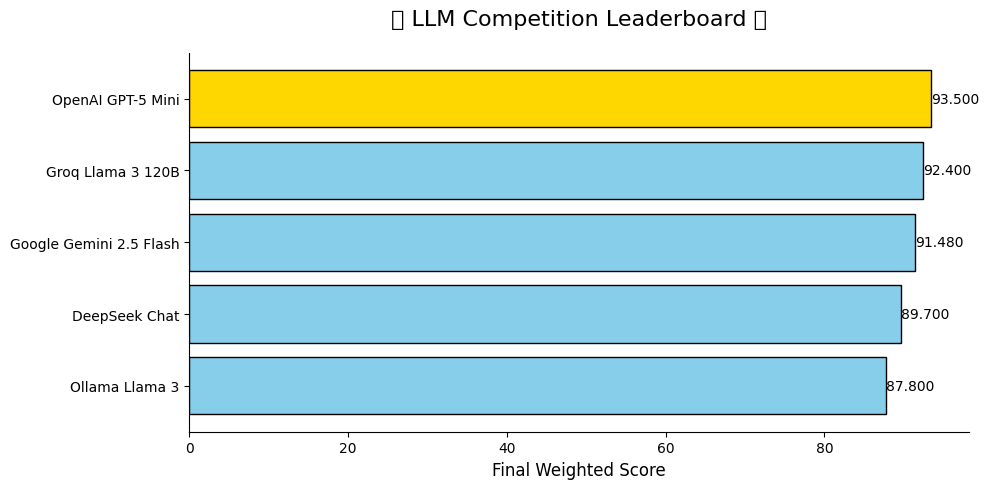

In [76]:

import matplotlib.pyplot as plt
import numpy as np

# This command ensures the plot displays inside the notebook
%matplotlib inline 

print("\n" + "=" * 50)
print("--- 📊 VISUAL LEADERBOARD 📊 ---")
print("=" * 50)

# Check if the final ranking data exists
if 'final_rankings_sorted' in globals() and final_rankings_sorted:
    
    # Reverse the data so the highest score is at the top of the chart
    final_rankings_display = final_rankings_sorted[::-1]
    
    # Separate model names and scores
    models = [r['model'] for r in final_rankings_display]
    scores = [r['final_score'] for r in final_rankings_display]
    
    # Create a color list (default 'skyblue', winner 'gold')
    colors = ['skyblue'] * (len(models) - 1)
    colors.append('gold') # The last item (highest score)
    
    # Dynamically adjust the figure height based on the number of models
    fig_height = max(5, len(models) * 0.7)
    plt.figure(figsize=(10, fig_height))
    
    # Create the horizontal bars
    bars = plt.barh(models, scores, color=colors, edgecolor='black')
    
    # Axis labels and title
    plt.xlabel('Final Weighted Score', fontsize=12)
    plt.title('🏆 LLM Competition Leaderboard 🏆', fontsize=16, pad=20)
    
    # Clean up the chart (remove top and right spines)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add score labels on the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01,  # Position label to the right of the bar
                 bar.get_y() + bar.get_height() / 2,
                 f'{width:.3f}', # Format score to 3 decimal places
                 va='center', 
                 ha='left',
                 fontsize=10)
    
    # Adjust left margin for long model names
    plt.tight_layout()
    
    # Display the plot
    plt.show()

else:
    print("❌ Leaderboard data not found. Please run the scoring cell (Stage 7) first.")

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">Which pattern(s) did this use? Try updating this to add another Agentic design pattern.
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">These kinds of patterns - to send a task to multiple models, and evaluate results,
            are common where you need to improve the quality of your LLM response. This approach can be universally applied
            to business projects where accuracy is critical.
            </span>
        </td>
    </tr>
</table>